In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *

In [2]:
def load_total_data(dataset_name, data_type, subject_list=[], rootrel=False, overwrite=False, verbose=False):
    if dataset_name == 'h36m_train': subject_list = ['S1', 'S5', 'S6', 'S7', 'S8']
    elif dataset_name == 'h36m_test': subject_list = ['S9', 'S11']
    elif dataset_name == 'h36m_total': subject_list = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']
    elif dataset_name == 'h36m_tr_s1_ts_s5678_train': subject_list = ['S1']
    elif dataset_name == 'h36m_tr_s1_ts_s5678_test': subject_list = ['S5', 'S6', 'S7', 'S8']
    elif dataset_name == 'fit3d_total': subject_list = ['s03', 's04', 's05', 's07', 's08', 's09', 's10', 's11']
    elif dataset_name == 'fit3d_tr_s03_train': subject_list = ['s03']
    elif dataset_name == 'fit3d_tr_s03_test': subject_list = ['s04', 's05', 's07', 's08', 's09', 's10', 's11']
    elif dataset_name == 'fit3d_ts_s4710_train': subject_list = ['s03', 's05', 's08', 's09', 's11']
    elif dataset_name == 'fit3d_ts_s4710_test': subject_list = ['s04', 's07', 's10']
    elif dataset_name == '3dhp_train': subject_list = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']
    elif dataset_name == '3dhp_test': subject_list = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']
    elif dataset_name == '3dhp_total': subject_list = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']
    assert len(subject_list) != 0, f"Please provide a list of subjects to load the data for {dataset_name}."

    # get total data
    save_path = f'custom_codes/dataset_distribution_analysis/pkls/{data_type}_total-{dataset_name}.pkl'
    if os.path.exists(save_path) and not overwrite:
        if verbose: print(f"Loading total data for {dataset_name} {data_type} {subject_list}...")
        data_total = readpkl(save_path)
    else:
        if verbose: print(f"Creating total data for {dataset_name} {data_type} {subject_list}...")
        if 'h36m' in dataset_name: dataset_name = 'h36m'
        elif 'fit3d' in dataset_name: dataset_name = 'fit3d'
        elif '3dhp' in dataset_name: dataset_name = '3dhp'

        if '_hat' in data_type:
            data_type = data_type.replace('_hat', '')
            rootrel = True
        if data_type in ['W', 'H', 'intrinsic']:
            data = load_data_dict(dataset_name, ['source_list', 'cam_param', 'cam_3d'], verbose=True)
        else:
            data = load_data_dict(dataset_name, ['source_list', 'cam_param', data_type], verbose=True)
            assert data_type in data.keys(), f"Invalid data type: {data_type}"

        # if 'train' in dataset_name_:  source_list = [source for source in source_list if 'TS' not in source]
        # elif 'test' in dataset_name_: source_list = [source for source in source_list if 'TS' in source]
        source_list = []
        for source in data['source_list']:
            subject, cam_id, _ = split_source_name(source, dataset_name)
            if subject in subject_list:
                if dataset_name == '3dhp' and cam_id not in ['cam0','cam1','cam2','cam4','cam5','cam6','cam7','cam8', None]: continue
                source_list.append(source)
        if verbose: print(source_list)
        data_total = []
        for source in tqdm(source_list):
            subject, cam_id, action = split_source_name(source, dataset_name)
            cam_param = data['cam_param'][subject][action][cam_id]
            if 'img_2d' in data_type:
                W, H = cam_param['W'], cam_param['H']
                img_2d = data[data_type][subject][action][cam_id]
                if 'pcl_original' not in data_type:
                    img_2d = normalize_input(img_2d, W, H)
                data_total += img_2d.tolist()
            elif data_type in ['W', 'H', 'intrinsic']:
                num_frames = data['cam_3d'][subject][action][cam_id].shape[0]
                data_total += [cam_param[data_type]]*num_frames
            else:
                if rootrel:
                    data_root = data[data_type][subject][action][cam_id].copy()
                    data_root -= data_root[:, 0:1]
                    data_total += data_root.tolist()
                else:
                    data_total += data[data_type][subject][action][cam_id].tolist()
        data_total = np.array(data_total)
        savepkl(data_total, save_path)
    return data_total

# Generate total data pkl

In [5]:
overwrite = False
dataset_name_list = ['3dhp_total'] # ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
data_type_list = ['cam_3d', 'cam_3d_canonical_revolute', 'img_2d', 'img_2d_canonical_revolute', 'W', 'H', 'intrinsic']

for dataset_name in dataset_name_list:
    for data_type in data_type_list:
        data_total = load_total_data(dataset_name, data_type, overwrite=overwrite)

[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...


100%|██████████| 134/134 [00:07<00:00, 18.36it/s]


[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_revolute...


100%|██████████| 134/134 [00:08<00:00, 15.02it/s]


[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP img_2d...


100%|██████████| 134/134 [00:08<00:00, 15.51it/s]


[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_revolute...


100%|██████████| 134/134 [00:06<00:00, 19.71it/s]


[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...


100%|██████████| 134/134 [00:00<00:00, 27196.20it/s]

[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...



100%|██████████| 134/134 [00:00<00:00, 68649.90it/s]


[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...


100%|██████████| 134/134 [00:00<00:00, 89983.47it/s]


# Joint distribution

In [7]:
from re import A
from tkinter import font


def plot_joint_position_distribution(poses,
                                     data_type='',
                                     joint_num=[0],
                                     grid_size=50,
                                     xz_limits=(-3, 3, 0, 7), xy_limits=(-3, 3, -2, 2), yz_limits=(-2, 2, 0, 7),
                                     label_fontsize=10,
                                     save_path=None,
                                     grid_lines=True,
                                     plt_show=False,
                                     figure_num=0,
                                     title="Pelvis Position Distribution",
                                     reverse_colormap=True,
                                     normalize_type='max_to_1',
                                     combine_type='max'):
    """
    Plots the pelvis joint position distribution on x-z and x-y planes using density grids.
    If 2D poses are provided, only the x-y plane is plotted.

    Parameters:
        poses (numpy.ndarray): Array of shape (F, 17, 3) or (F, 17, 2) representing the 3D or 2D poses.
        grid_size (int): An integer for the base resolution of the grid for density estimation.
        xz_limits (tuple): Optional tuple (x_min, x_max, z_min, z_max) for x-z plane limits.
        xy_limits (tuple): Optional tuple (x_min, x_max, y_min, y_max) for x-y plane limits.
        save_path (str): Optional path to save the figure as an image file. If None, the figure is not saved.
        grid_lines (bool): If True, grid lines are drawn on the plots. Default is True.
        figure_num (str or int): Identifier for the figure window. Default is "Pelvis Position Distribution".
        reverse_colormap (bool): If True, reverse the colormap. Default is False.
        normalize_type (str): 'sum_to_1' or 'max_to_1'
        mean_type (str): 'mean' or 'max'
    """
    # Determine whether the input is 2D or 3D
    is_2d = poses.shape[-1] == 2

    if not isinstance(joint_num, list): joint_num = [joint_num]
    # Extract the pelvis joint positions

    if is_2d:
        xy_hist_list = None
        if 'pcl_original' in data_type: grid_size *= 2
        for joint_idx in joint_num:
            joint_positions = poses[:, joint_idx, :]  # Assuming the pelvis is the 0th joint

            x = joint_positions[:, 0]
            y = joint_positions[:, 1]
            if xy_limits:
                x_min_xy, x_max_xy, y_min, y_max = xy_limits
                if 'pcl_original' in data_type:
                    x_min_xy -= 1
                    x_max_xy += 1
                    y_min -= 1
                    y_max += 1
            else:
                x_min_xy, x_max_xy = x.min(), x.max()
                y_min, y_max = y.min(), y.max()

            # Create 2D histogram for x-y
            xy_hist, xy_xedges, xy_yedges = np.histogram2d(x, y, bins=grid_size, range=[[x_min_xy, x_max_xy], [y_min, y_max]])

            # Normalize the histogram to represent probabilities
            if normalize_type == 'sum_to_1':   xy_hist /= np.sum(xy_hist) # Normalize the histogram to represent probabilities (sum to 1)
            elif normalize_type == 'max_to_1': xy_hist = (xy_hist - np.min(xy_hist))/(np.max(xy_hist) - np.min(xy_hist))# Normalize the histogram to represent probabilities
            else: pass # No normalization

            # Combine histograms
            if combine_type == 'mean': # Combine histograms by averaging
                if xy_hist_list is None: xy_hist_list = xy_hist/len(joint_num)
                else:                    xy_hist_list += xy_hist/len(joint_num)
            elif combine_type == 'max': # Combine histograms by taking the maximum
                if xy_hist_list is None: xy_hist_list = xy_hist
                else:                    xy_hist_list = np.maximum(xy_hist_list, xy_hist)

        xy_hist = xy_hist_list

        # Select colormap
        colormap = 'gray_r' if reverse_colormap else 'gray'

        # Clear the current figure to prevent overlap
        plt.figure(num=figure_num, figsize=(6, 6))
        plt.clf()

        # Plot density for x-y plane
        plt.title(title)
        plt.xlabel("X-axis (in camera frame)")
        plt.ylabel("Y-axis (in camera frame)")
        mesh = plt.pcolormesh(xy_xedges, xy_yedges, xy_hist.T, shading='auto', cmap=colormap)
        plt.colorbar(mesh, label='Density (Probability)', shrink=0.4, aspect=15).ax.tick_params(labelsize=8)  # Adjust color bar size and width
        if 'pcl_original' in data_type:
            x_min_xy += 1
            x_max_xy -= 1
            y_min += 1
            y_max -= 0.8
        plt.xlim(x_min_xy, x_max_xy)
        plt.ylim(y_max, y_min)
        plt.gca().set_aspect('equal', adjustable='box')

        # Add grid lines for x-y plane if enabled
        if grid_lines:
            for xc in xy_xedges:
                plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
            for yc in xy_yedges:
                plt.axhline(y=yc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

        plt.tight_layout()

        # Save the figure if a path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        if plt_show:
            plt.show()

    else:
        xz_hist_list = None
        xy_hist_list = None
        yz_hist_list = None
        for joint_idx in joint_num:
            joint_positions = poses[:, joint_idx, :]  # Assuming the pelvis is the 0th joint

            x = joint_positions[:, 0]
            y = joint_positions[:, 1]
            z = joint_positions[:, 2]


            # Adjust grid ranges based on limits if provided
            if xz_limits:
                x_min_xz, x_max_xz, z_min_xz, z_max_xz = xz_limits
            else:
                x_min_xz, x_max_xz = x.min(), x.max()
                z_min_xz, z_max_xz = z.min(), z.max()

            if xy_limits:
                x_min_xy, x_max_xy, y_min_xy, y_max_xy = xy_limits
            else:
                x_min_xy, x_max_xy = x.min(), x.max()
                y_min_xy, y_max_xy = y.min(), y.max()

            if yz_limits:
                y_min_yz, y_max_yz, z_min_yz, z_max_yz = yz_limits
            else:
                y_min_yz, y_max_yz = y.min(), y.max()
                z_min_yz, z_max_yz = z.min(), z.max()

            # Calculate proportional grid sizes
            xz_range_x = x_max_xz - x_min_xz
            xz_range_z = z_max_xz - z_min_xz
            xy_range_x = x_max_xy - x_min_xy
            xy_range_y = y_max_xy - y_min_xy
            yz_range_y = y_max_yz - y_min_yz
            yz_range_z = z_max_yz - z_min_yz

            grid_size_xz_x = int(grid_size * (xz_range_x / max(xz_range_x, xz_range_z)))
            grid_size_xz_z = int(grid_size * (xz_range_z / max(xz_range_x, xz_range_z)))

            grid_size_xy_x = int(grid_size * (xy_range_x / max(xy_range_x, xy_range_y)))
            grid_size_xy_y = int(grid_size * (xy_range_y / max(xy_range_x, xy_range_y)))

            grid_size_yz_y = int(grid_size * (yz_range_y / max(yz_range_y, yz_range_z)))
            grid_size_yz_z = int(grid_size * (yz_range_z / max(yz_range_y, yz_range_z)))

            # Create 2D histograms for x-z and x-y
            xz_hist, xz_xedges, xz_zedges = np.histogram2d(x, z, bins=[grid_size_xz_x, grid_size_xz_z], range=[[x_min_xz, x_max_xz], [z_min_xz, z_max_xz]])
            xy_hist, xy_xedges, xy_yedges = np.histogram2d(x, y, bins=[grid_size_xy_x, grid_size_xy_y], range=[[x_min_xy, x_max_xy], [y_min_xy, y_max_xy]])
            yz_hist, yz_yedges, yz_zedges = np.histogram2d(y, z, bins=[grid_size_yz_y, grid_size_yz_z], range=[[y_min_yz, y_max_yz], [z_min_yz, z_max_yz]])

            # Normalize the histogram to represent probabilities
            if normalize_type == 'sum_to_1': # Normalize the histogram to represent probabilities (sum to 1)
                xy_hist /= np.sum(xy_hist)
                xz_hist /= np.sum(xz_hist)
                yz_hist /= np.sum(yz_hist)
            elif normalize_type == 'max_to_1': # Normalize the histogram to represent probabilities
                xy_hist = (xy_hist - np.min(xy_hist))/(np.max(xy_hist) - np.min(xy_hist))
                xz_hist = (xz_hist - np.min(xz_hist))/(np.max(xz_hist) - np.min(xz_hist))
                yz_hist = (yz_hist - np.min(yz_hist))/(np.max(yz_hist) - np.min(yz_hist))
            else: pass # No normalization

            # Combine histograms
            if combine_type == 'mean': # Combine histograms by averaging
                if xy_hist_list is None: xy_hist_list = xy_hist/len(joint_num)
                else:                    xy_hist_list += xy_hist/len(joint_num)
                if xz_hist_list is None: xz_hist_list = xz_hist/len(joint_num)
                else:                    xz_hist_list += xz_hist/len(joint_num)
                if yz_hist_list is None: yz_hist_list = yz_hist/len(joint_num)
                else:                    yz_hist_list += yz_hist/len(joint_num)
            elif combine_type == 'max': # Combine histograms by taking the maximum
                if xy_hist_list is None: xy_hist_list = xy_hist
                else:                    xy_hist_list = np.maximum(xy_hist_list, xy_hist)
                if xz_hist_list is None: xz_hist_list = xz_hist
                else:                    xz_hist_list = np.maximum(xz_hist_list, xz_hist)
                if yz_hist_list is None: yz_hist_list = yz_hist
                else:                    yz_hist_list = np.maximum(yz_hist_list, yz_hist)

        xy_hist = xy_hist_list
        xz_hist = xz_hist_list
        yz_hist = yz_hist_list

        # Select colormap
        colormap = 'gray_r' if reverse_colormap else 'gray'

        # Clear the current figure to prevent overlap
        fig = plt.figure(num=figure_num, figsize=(6, 6))
        #plt.clf()
        fig.clear()
        plt.suptitle(title)

        axd = fig.subplot_mosaic(
            """
            A
            """,
            #per_subplot_kw={('A', 'B', 'C'): {'projection': '3d'}}
        )

        # Plot density for x-z plane
        # plt.subplot(2, 2, 1)
        # plt.title("Joint Position Distribution (X-Z Plane)")
        # plt.xlabel("X-axis (in camera frame)")
        # plt.ylabel("Z-axis (in camera frame)")
        # mesh_xz = plt.pcolormesh(xz_xedges, xz_zedges, xz_hist.T, shading='auto', cmap=colormap)
        # plt.xlim(x_min_xz, x_max_xz)
        # plt.ylim(z_min_xz, z_max_xz)
        # plt.gca().set_aspect('equal', adjustable='box')
        mesh_xz = axd['A'].pcolormesh(xz_xedges, xz_zedges, xz_hist.T, shading='auto', cmap=colormap)
        axd['A'].set_xlabel("X-axis (in camera frame)", fontsize=label_fontsize)
        axd['A'].set_ylabel("Z-axis (in camera frame)", fontsize=label_fontsize)
        axd['A'].set_xlim(x_min_xz, x_max_xz)
        axd['A'].set_ylim(z_min_xz, z_max_xz)
        axd['A'].set_aspect('equal', adjustable='box')

        # Add grid lines for x-z plane if enabled
        if grid_lines:
            for xc in xz_xedges:
                #plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
                axd['A'].axvline(x=xc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
            for zc in xz_zedges:
                #plt.axhline(y=zc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
                axd['A'].axhline(y=zc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

        # # Plot density for y-z plane
        # # plt.subplot(2, 2, 2)
        # # plt.title("Joint Position Distribution (Y-Z Plane)")
        # # plt.xlabel("Y-axis (in camera frame)")
        # # plt.ylabel("Z-axis (in camera frame)")
        # # mesh_yz = plt.pcolormesh(yz_yedges, yz_zedges, yz_hist.T, shading='auto', cmap=colormap)
        # # plt.xlim(y_min_yz, y_max_yz)
        # # plt.ylim(z_min_yz, z_max_yz)
        # # plt.gca().set_aspect('equal', adjustable='box')
        # mesh_yz = axd['B'].pcolormesh(yz_yedges, yz_zedges, yz_hist.T, shading='auto', cmap=colormap)
        # axd['B'].set_xlabel("Y-axis (in camera frame)", fontsize=label_fontsize)
        # axd['B'].set_ylabel("Z-axis (in camera frame)", fontsize=label_fontsize)
        # axd['B'].set_xlim(y_min_yz, y_max_yz)
        # axd['B'].set_ylim(z_min_yz, z_max_yz)
        # axd['B'].set_aspect('equal', adjustable='box')

        # # Add grid lines for y-z plane if enabled
        # if grid_lines:
        #     for yc in yz_yedges:
        #         #plt.axvline(x=yc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        #         axd['B'].axvline(x=yc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        #     for zc in yz_zedges:
        #         #plt.axhline(y=zc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        #         axd['B'].axhline(y=zc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot density for x-y plane
        # plt.subplot(2, 2, 3)
        # plt.title("Joint Position Distribution (X-Y Plane)")
        # plt.xlabel("X-axis (in camera frame)")
        # plt.ylabel("Y-axis (in camera frame)")
        # mesh_xy = plt.pcolormesh(xy_xedges, xy_yedges, xy_hist.T, shading='auto', cmap=colormap)
        # plt.xlim(x_min_xy, x_max_xy)
        # plt.ylim(y_max_xy, y_min_xy)
        # plt.gca().set_aspect('equal', adjustable='box')
        # mesh_xy = axd['C'].pcolormesh(xy_xedges, xy_yedges, xy_hist.T, shading='auto', cmap=colormap)
        # axd['C'].set_xlabel("X-axis (in camera frame)", fontsize=label_fontsize)
        # axd['C'].set_ylabel("Y-axis (in camera frame)", fontsize=label_fontsize)
        # axd['C'].set_xlim(x_min_xy, x_max_xy)
        # axd['C'].set_ylim(y_max_xy, y_min_xy)
        # axd['C'].set_aspect('equal', adjustable='box')

        # # Add grid lines for x-y plane if enabled
        # if grid_lines:
        #     for xc in xy_xedges:
        #         #plt.axvline(x=xc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        #         axd['C'].axvline(x=xc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        #     for yc in xy_yedges:
        #         #plt.axhline(y=yc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        #         axd['C'].axhline(y=yc, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

        # Add a single color bar for both plots
        cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])  # Position for a single color bar
        plt.colorbar(mesh_xz, cax=cbar_ax, label='Density (Probability)').ax.tick_params(labelsize=8)

        plt.tight_layout(rect=[0, 0, 0.9, 1])

        # Save the figure if a path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

        if plt_show:
            plt.show()

    return xy_hist



### Test plot

/tmp/ipykernel_220176/574579246.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


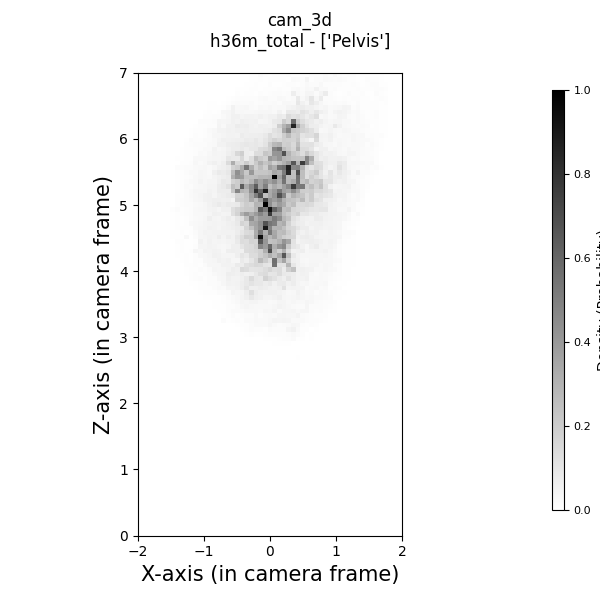

In [20]:
grid_size = 100
overwrite = False
dataset_name = 'h36m_total'
data_type = 'cam_3d'
joint_name = ['Pelvis'] # ['total']
h36m_keypoints = ['Pelvis','R_Hip','R_Knee','R_Ankle','L_Hip','L_Knee','L_Ankle','Torso','Neck','Nose','Head','L_Shoulder','L_Elbow','L_Wrist','R_Shoulder','R_Elbow','R_Wrist']
if 'hat' in data_type: xz_limits = (-2, 2, -2, 2)
else:                  xz_limits = (-2, 2, 0, 7)
if 'img_2d' in data_type:
    if 'pcl_original' in data_type: xy_limits = (0, 1, 0, 1)
    else:                           xy_limits = (-1, 1, -1, 1)
else:                               xy_limits = (-2, 2, -2, 2)

if 'total' in joint_name: joint_idxs = get_h36m_keypoint_index(h36m_keypoints)
else:                     joint_idxs = get_h36m_keypoint_index(joint_name)

poses = load_total_data(dataset_name, data_type, overwrite=overwrite)
xy_hist = plot_joint_position_distribution(poses,
                                           data_type,
                                           joint_num=joint_idxs,
                                           grid_size=grid_size,
                                           grid_lines=False,
                                           xy_limits=xy_limits,
                                           xz_limits=xz_limits,
                                           label_fontsize=15,
                                           plt_show=True,
                                           normalize_type='max_to_1',
                                           combine_type='max',
                                           title=f'{data_type}\n{dataset_name} - {joint_name}')


### Save plot

In [ ]:
grid_size = 100
overwrite = False
overdraw = True
dataset_name_list = ['h36m_total', 'fit3d_total', '3dhp_total'] # ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
data_type_list = ['cam_3d', 'img_2d', 'cam_3d_hat', 'cam_3d_canonical_revolute', 'cam_3d_canonical_revolute_hat', 'img_2d_canonical_revolute'] # ['cam_3d', 'cam_3d_canonical_revolute', 'img_2d', 'img_2d_canonical_revolute', 'img_2d_canonical_pcl_original', 'cam_3d_hat', 'cam_3d_canonical_revolute_hat']
h36m_keypoints = ['Pelvis','R_Hip','R_Knee','R_Ankle','L_Hip','L_Knee','L_Ankle','Torso','Neck','Nose','Head','L_Shoulder','L_Elbow','L_Wrist','R_Shoulder','R_Elbow','R_Wrist']
keypoint_list = ['Pelvis', 'total'] # ['Pelvis','R_Hip','R_Knee','R_Ankle','L_Hip','L_Knee','L_Ankle','Torso','Neck','Nose','Head','L_Shoulder','L_Elbow','L_Wrist','R_Shoulder','R_Elbow','R_Wrist', 'total']

pbar = tqdm(dataset_name_list)
for dataset_name in pbar:
    for data_type in data_type_list:
        poses = load_total_data(dataset_name, data_type, overwrite=overwrite)
        plot_save_folder = f'custom_codes/dataset_distribution_analysis/plots/{data_type}_{dataset_name}'
        if not os.path.exists(plot_save_folder): os.makedirs(plot_save_folder)
        for joint_name in keypoint_list:
            pbar.set_postfix({'dataset_name': dataset_name, 'data_type': data_type, 'joint': joint_name})
            if joint_name == 'total': joint_idxs = get_h36m_keypoint_index(h36m_keypoints)
            else:                     joint_idxs = [get_h36m_keypoint_index(joint_name)]
            plot_save_path = os.path.join(plot_save_folder, f'{dataset_name}_{data_type}_{joint_name}_distribution_gs_{grid_size}.svg')
            if os.path.exists(plot_save_path) and not overdraw:
                print(f"Skipping {dataset_name} {data_type} {joint_name}...")
                continue
            if 'img_2d' in data_type:
                if 'pcl_original' in data_type: xy_limits = (0, 1, 0, 1)
                else:                           xy_limits = (-1, 1, -1, 1)
            else:
                xy_limits = (-2, 2, -2, 2)
                if 'hat' in data_type: xz_limits = (-2, 2, -2, 2)
                else:                  xz_limits = (-2, 2, 0, 7)
            plot_joint_position_distribution(poses,
                                             data_type,
                                             joint_num=joint_idxs,
                                             grid_size=grid_size,
                                             grid_lines=False,
                                             xy_limits=xy_limits,
                                             xz_limits=xz_limits,
                                             label_fontsize=15,
                                             plt_show=False,
                                             save_path=plot_save_path,
                                             title='',#f'{data_type}\n{dataset_name} - {joint_name}'
                                             )


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s, dataset_name=h36m_total, data_type=cam_3d_canonical_revolute, joint=Pelvis]/tmp/ipykernel_237570/1378855152.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
100%|██████████| 3/3 [00:11<00:00,  3.86s/it, dataset_name=3dhp_total, data_type=cam_3d_canonical_revolute, joint=total]  


In [16]:
# copy total plot to a single folder
import shutil

dataset_name_list = ['h36m_total', 'fit3d_total', '3dhp_total'] # ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
data_type_list = ['cam_3d', 'img_2d', 'cam_3d_canonical_revolute', 'cam_3d_hat', 'cam_3d_canonical_revolute_hat', 'img_2d_canonical_revolute']
keypoint_list = ['total', 'Pelvis']

for keypoint in keypoint_list:
    plot_save_folder = f'custom_codes/dataset_distribution_analysis/plots_{keypoint}'
    if not os.path.exists(plot_save_folder): os.makedirs(plot_save_folder)
    else:
        # remove existing folder
        shutil.rmtree(plot_save_folder)
        os.makedirs(plot_save_folder)
    for dataset_name in dataset_name_list:
        for data_type in data_type_list:
            plot_load_folder = f'custom_codes/dataset_distribution_analysis/plots/{data_type}_{dataset_name}'
            plot_path = os.path.join(plot_load_folder, f'{dataset_name}_{data_type}_{keypoint}_distribution_gs_{grid_size}.svg')
            assert os.path.exists(plot_load_folder), f"Total plot not found for {dataset_name} {data_type} {keypoint} {plot_load_folder}"
            shutil.copy(plot_path, os.path.join(plot_save_folder, f'{dataset_name}_{data_type}_{keypoint}_distribution_gs_{grid_size}.svg'))

# Length ratio

In [ ]:
len_ids = {
    'R_HIP' : 0,
    'R_UPPER_LEG' : 1,
    'R_LOWER_LEG' : 2,
    'L_HIP' : 3,
    'L_UPPER_LEG' : 4,
    'L_LOWER_LEG' : 5,
    'LOWER_TORSO' : 6,
    'UPPER_TORSO' : 7,
    'LOWER_FACE' : 8,
    'UPPER_FACE' : 9,
    'L_SHOULDER' : 10,
    'L_UPPER_ARM' : 11,
    'L_LOWER_ARM' : 12,
    'R_SHOULDER' : 13,
    'R_UPPER_ARM' : 14,
    'R_LOWER_ARM' : 15
}

In [ ]:
cam_3d = load_total_data('h36m_train', 'cam_3d')
W = load_total_data('h36m_train', 'W')
H = load_total_data('h36m_train', 'H')
intrinsic = load_total_data('h36m_train', 'intrinsic')
fx, fy, cx, cy = intrinsic[:, 0, 0], intrinsic[:, 1, 1], intrinsic[:, 0, 2], intrinsic[:, 1, 2]

In [ ]:
cam_3d.shape, W.shape, H.shape, intrinsic.shape, fx.shape, fy.shape, cx.shape, cy.shape

((1559752, 17, 3),
 (1559752,),
 (1559752,),
 (1559752, 3, 3),
 (1559752,),
 (1559752,),
 (1559752,),
 (1559752,))

In [ ]:
# single pose
pose3d = cam_3d[0]
length = get_h36m_limb_lens(pose3d)[0]
assert length[len_ids['R_HIP']] == np.linalg.norm(pose3d[get_h36m_keypoint_index(['R_Hip'])] - pose3d[get_h36m_keypoint_index(['Pelvis'])]), f"Length mismatch for R_HIP"
length[len_ids['R_HIP']], length[len_ids['L_HIP']], length[len_ids['R_HIP']] + length[len_ids['L_HIP']]

(0.1329485983171822, 0.1329488217719619, 0.2658974200891441)

In [ ]:
lengths = get_h36m_limb_lens(cam_3d)
lengths.shape

(1559752, 16)

In [ ]:
l_btw_hips = lengths[:, len_ids['R_HIP']] + lengths[:, len_ids['L_HIP']]
base_length = l_btw_hips

length_r_upper_leg = lengths[:, len_ids['R_UPPER_LEG']]
length_r_lower_leg = lengths[:, len_ids['R_LOWER_LEG']]
length_l_upper_leg = lengths[:, len_ids['L_UPPER_LEG']]
length_l_lower_leg = lengths[:, len_ids['L_LOWER_LEG']]
length_r_upper_arm = lengths[:, len_ids['R_UPPER_ARM']]
length_r_lower_arm = lengths[:, len_ids['R_LOWER_ARM']]
length_l_upper_arm = lengths[:, len_ids['L_UPPER_ARM']]
length_l_lower_arm = lengths[:, len_ids['L_LOWER_ARM']]

ratio_r_upper_leg = length_r_upper_leg / base_length
ratio_r_lower_leg = length_r_lower_leg / base_length
ratio_l_upper_leg = length_l_upper_leg / base_length
ratio_l_lower_leg = length_l_lower_leg / base_length
ratio_r_upper_arm = length_r_upper_arm / base_length
ratio_r_lower_arm = length_r_lower_arm / base_length
ratio_l_upper_arm = length_l_upper_arm / base_length
ratio_l_lower_arm = length_l_lower_arm / base_length

In [ ]:
ratios = {}
for key in len_ids.keys():
    ratios[key] = lengths[:, len_ids[key]] / base_length

In [ ]:
ratios['R_HIP'].shape

(1559752,)

# Scale distribution

### Canonical depth

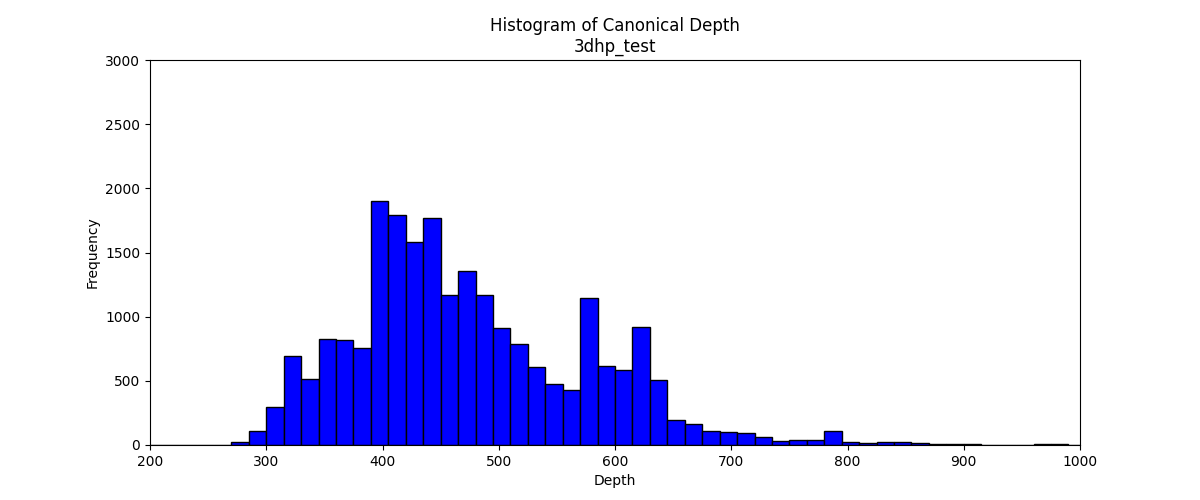

In [18]:
dataset_name = '3dhp_test'

cam_3d = load_total_data(dataset_name, 'cam_3d')
W = load_total_data(dataset_name, 'W')
H = load_total_data(dataset_name, 'H')
intrinsic = load_total_data(dataset_name, 'intrinsic')
fx, fy, cx, cy = intrinsic[:, 0, 0], intrinsic[:, 1, 1], intrinsic[:, 0, 2], intrinsic[:, 1, 2]
f = np.max([fx.reshape(-1, 1), fy.reshape(-1, 1)], axis=0)[:, 0]
z = cam_3d[:, 0, 2]
canonical_depth = f/z

# plot the histogram for the canonical depth
plt.figure(num='Histogram of Canonical Depth (f/z)', figsize=(12, 5))
plt.clf()
plt.hist(canonical_depth, bins=100, range=(0, 1500), color='blue', edgecolor='black')
plt.title(f'Histogram of Canonical Depth\n{dataset_name}')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.xlim(200, 1000)
plt.ylim(0, 3000)

plt.show()

In [17]:
dataset_name_list = ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
for dataset_name in dataset_name_list:
    cam_3d = load_total_data(dataset_name, 'cam_3d')
    W = load_total_data(dataset_name, 'W')
    H = load_total_data(dataset_name, 'H')
    intrinsic = load_total_data(dataset_name, 'intrinsic')
    fx, fy, cx, cy = intrinsic[:, 0, 0], intrinsic[:, 1, 1], intrinsic[:, 0, 2], intrinsic[:, 1, 2]
    f = np.max([fx.reshape(-1, 1), fy.reshape(-1, 1)], axis=0)[:, 0]
    z = cam_3d[:, 0, 2]
    canonical_depth = f/z

    # plot the histogram for the canonical depth
    plt.figure(num='Histogram of Canonical Depth (f/z)', figsize=(12, 5))
    plt.clf()
    plt.hist(canonical_depth, bins=100, range=(0, 1500), color='blue', edgecolor='black')
    plt.title(f'Histogram of Canonical Depth\n{dataset_name}')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    plt.xlim(0, 1500)
    plt.ylim(0, 800000)
    save_folder = 'custom_codes/dataset_distribution_analysis/plots/canonical_depth'
    if not os.path.exists(save_folder): os.makedirs(save_folder)
    save_path = os.path.join(save_folder, f'canonical_depth_distribution_{dataset_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [12]:
dataset_name_list = ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
for dataset_name in dataset_name_list:
    cam_3d = load_total_data(dataset_name, 'cam_3d_canonical_revolute')
    W = load_total_data(dataset_name, 'W')
    H = load_total_data(dataset_name, 'H')
    intrinsic = load_total_data(dataset_name, 'intrinsic')
    fx, fy, cx, cy = intrinsic[:, 0, 0], intrinsic[:, 1, 1], intrinsic[:, 0, 2], intrinsic[:, 1, 2]
    f = np.max([fx.reshape(-1, 1), fy.reshape(-1, 1)], axis=0)[:, 0]
    z = cam_3d[:, 0, 2]
    canonical_depth = f/z

    # plot the histogram for the canonical depth
    plt.figure(num='Histogram of Canonical Depth (f/z)', figsize=(12, 5))
    plt.clf()
    plt.hist(canonical_depth, bins=100, range=(0, 1500), color='blue', edgecolor='black')
    plt.title(f'Histogram of Canonical Depth\n{dataset_name}')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    plt.xlim(0, 1500)
    plt.ylim(0, 800000)
    save_folder = 'custom_codes/dataset_distribution_analysis/plots/canonical_depth'
    if not os.path.exists(save_folder): os.makedirs(save_folder)
    save_path = os.path.join(save_folder, f'canonical_depth_revolute_distribution_{dataset_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

### 2D pose scale

In [19]:
dataset_name = 'h36m_train'
img_2d = load_total_data('h36m_train', 'img_2d')
img_2d_hat = img_2d.copy() - img_2d[:, 0:1]
scale = np.linalg.norm(img_2d_hat.reshape(-1, 34), axis=1)

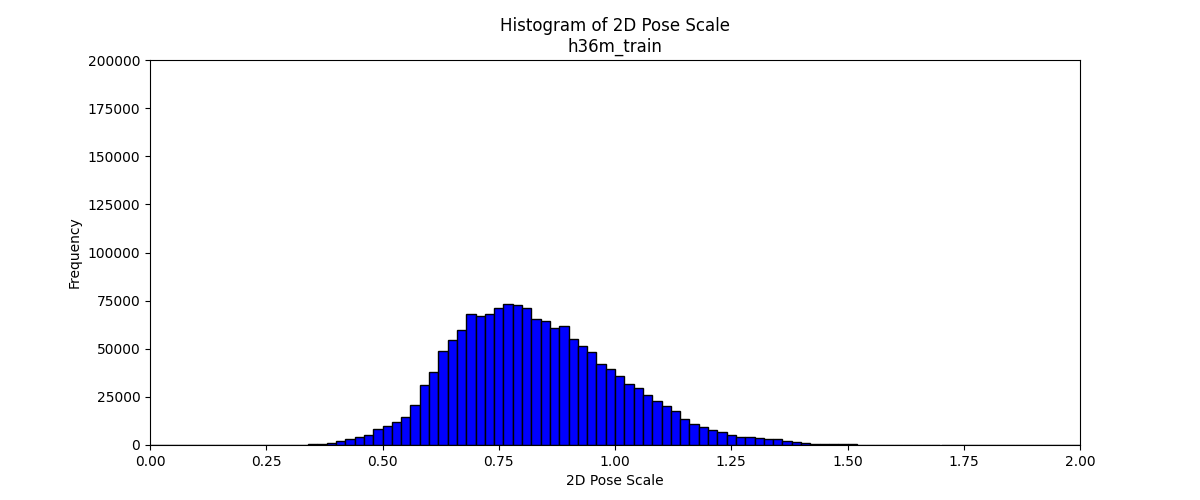

In [22]:
# plot the histogram for the canonical depth
plt.figure(num='Histogram of 2D Pose Scale', figsize=(12, 5))
plt.clf()
hist = plt.hist(scale, bins=100, range=(0, 2), color='blue', edgecolor='black')
plt.title(f'Histogram of 2D Pose Scale\n{dataset_name}')
plt.xlabel('2D Pose Scale')
plt.ylabel('Frequency')
plt.xlim(0, 2)
plt.ylim(0, 200000)
plt.show()

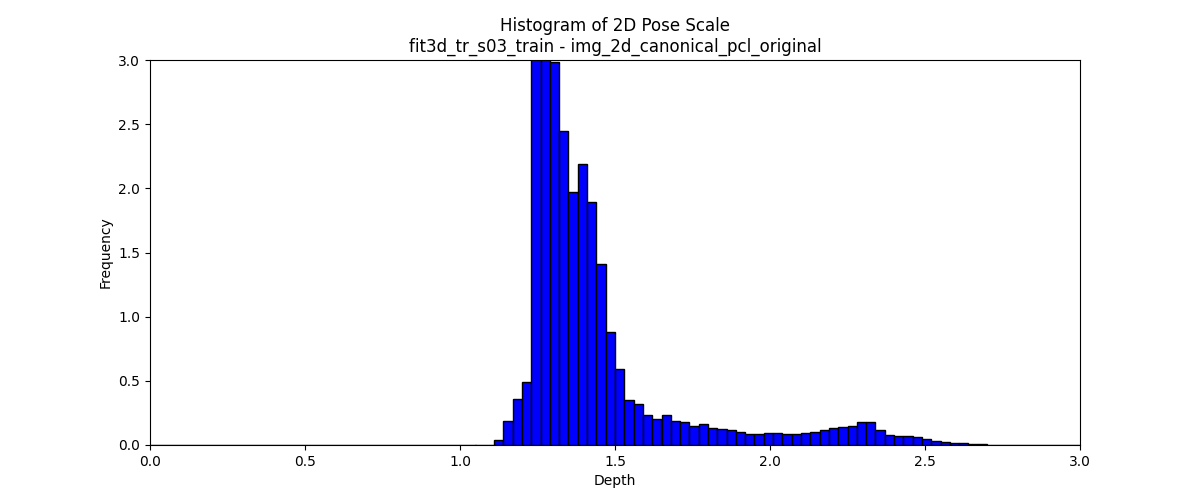

In [13]:
dataset_name_list = ['h36m_train', 'h36m_test', 'fit3d_total', '3dhp_train', '3dhp_test', 'fit3d_tr_s03_train'] # ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
data_type_list = ['img_2d', 'img_2d_canonical_revolute', 'img_2d_canonical_pcl_original']
for dataset_name in dataset_name_list:
    for data_type in data_type_list:
        img_2d = load_total_data(dataset_name, data_type)
        img_2d_hat = img_2d.copy() - img_2d[:, 0:1]
        scale = np.linalg.norm(img_2d_hat.reshape(-1, 34), axis=1)

        # plot the histogram for the canonical depth
        plt.figure(num='Histogram of 2D Pose Scale', figsize=(12, 5))
        plt.clf()
        plt.hist(scale, bins=100, range=(0, 3), density=True, color='blue', edgecolor='black')
        plt.title(f'Histogram of 2D Pose Scale\n{dataset_name} - {data_type}')
        plt.xlabel('Depth')
        plt.ylabel('Frequency')
        plt.xlim(0, 3)
        plt.ylim(0, 3)
        save_folder = 'custom_codes/dataset_distribution_analysis/plots/2d_pose_scale'
        if not os.path.exists(save_folder): os.makedirs(save_folder)
        save_path = os.path.join(save_folder, f'{data_type}_scale_{dataset_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

### 3D pose scale

In [68]:
dataset_name_list = ['h36m_train', 'h36m_test', 'fit3d_total', '3dhp_train', '3dhp_test'] # ['h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test', 'fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test', '3dhp_train', '3dhp_test']
data_type_list = ['cam_3d', 'cam_3d_canonical_revolute']
for dataset_name in dataset_name_list:
    for data_type in data_type_list:
        cam_3d = load_total_data(dataset_name, data_type)
        #cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
        #scale = np.linalg.norm(cam_3d_hat.reshape(-1, 51), axis=1)
        lengths = get_h36m_limb_lens(cam_3d)
        scale = np.linalg.norm(lengths, axis=1)

        # plot the histogram for the canonical depth
        plt.figure(num='Histogram of 3D Pose Scale', figsize=(12, 5))
        plt.clf()
        hist = plt.hist(scale, bins=200, range=(0, 2), density=True, color='blue', edgecolor='black')
        plt.title(f'Histogram of 3D Pose Scale\n{dataset_name} - {data_type}')
        plt.xlabel('Depth')
        plt.ylabel('Frequency')
        plt.xlim(0, 2)
        plt.ylim(0, 50)
        save_folder = 'custom_codes/dataset_distribution_analysis/plots/3d_pose_scale'
        if not os.path.exists(save_folder): os.makedirs(save_folder)
        save_path = os.path.join(save_folder, f'{data_type}_scale_{dataset_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Camera-relative pose distribution

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def rotation_to_spherical(rotations):
    """
    Convert the z-axis of rotation matrices to spherical coordinates.
    """
    z_axes = rotations[:, :, 2]
    x, y, z = z_axes[:, 0], z_axes[:, 1], z_axes[:, 2]
    azimuth = np.arctan2(y, x)
    elevation = np.arcsin(z)
    return azimuth, elevation

def compute_2d_histogram(azimuth, elevation, bins=50, range=None):
    """
    Compute a 2D histogram of spherical coordinates.
    """
    hist, xedges, yedges = np.histogram2d(azimuth, elevation, bins=bins, range=range, density=False)
    return hist, xedges, yedges

def plot_2d_histograms(hist1, hist2, xedges, yedges, dataset1='Dataset 1', dataset2='Dataset 2', fig_num='histogram', plt_show=True):
    """
    Plot two 2D histograms side by side for visual comparison.
    """
    fig = plt.figure(num=fig_num, figsize=(6, 6))
    fig.clear()
    axes = fig.subplots(3, 3)

    vmin = min(hist1.min(), hist2.min())
    vmax = max(hist1.max(), hist2.max())

    hist1 = np.where((hist1 > 0), 1, 0)
    hist2 = np.where((hist2 > 0), 1, 0)

    # Plot first histogram
    im1 = axes[0][0].imshow(hist1.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), cmap='gray_r', aspect='auto') # vmin=vmin, vmax=vmax,
    axes[0][0].set_title(dataset1)
    axes[0][0].set_xlabel("Azimuth (θ)")
    axes[0][0].set_ylabel("Elevation (ϕ)")
    #plt.colorbar(im1, ax=axes[0])

    # Plot second histogram
    im2 = axes[0][2].imshow(hist2.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), cmap='gray_r', aspect='auto') # vmin=vmin, vmax=vmax,
    axes[0][2].set_title(dataset2)
    axes[0][2].set_xlabel("Azimuth (θ)")
    axes[0][2].set_ylabel("Elevation (ϕ)")
    #plt.colorbar(im2, ax=axes[1])

    """
    Plot the common part of two 2D histograms.

    Parameters:
        hist1 (numpy.ndarray): First 2D histogram.
        hist2 (numpy.ndarray): Second 2D histogram.
        xedges (numpy.ndarray): Bin edges for azimuth.
        yedges (numpy.ndarray): Bin edges for elevation.
    """
    # Compute the minimum of the two histograms (common part)
    common_hist = np.where((hist1 > 0) & (hist2 > 0), 1, 0)
    sum_hist = np.where((hist1 > 0) | (hist2 > 0), 1, 0)

    # Plot the common histogram
    im3 = axes[1][1].imshow(common_hist.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),  cmap='gray_r', aspect='auto')
    axes[1][1].set_xlabel("Azimuth (θ)")
    axes[1][1].set_ylabel("Elevation (ϕ)")
    axes[1][1].set_title("Common Part of Two Histograms")
    #plt.colorbar(im1, ax=axes[0])

    # Plot the sum histogram
    im4 = axes[0][1].imshow(sum_hist.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), cmap='gray_r', aspect='auto')
    axes[0][1].set_xlabel("Azimuth (θ)")
    axes[0][1].set_ylabel("Elevation (ϕ)")
    axes[0][1].set_title("Sum of Two Histograms")
    #plt.colorbar(im2, ax=axes[1])

    """
    Plot parts where one histogram has nonzero values and the other has zeros.

    Parameters:
        hist1 (numpy.ndarray): First 2D histogram.
        hist2 (numpy.ndarray): Second 2D histogram.
        xedges (numpy.ndarray): Bin edges for azimuth.
        yedges (numpy.ndarray): Bin edges for elevation.
    """
    # Find regions where hist1 is non-zero and hist2 is zero
    hist1_exclusive = np.where((hist1 > 0) & (hist2 == 0), 1, 0)

    # Find regions where hist2 is non-zero and hist1 is zero
    hist2_exclusive = np.where((hist2 > 0) & (hist1 == 0), 1, 0)

    # Find regions where both histograms have no values
    hist_no_values = np.where((hist1 == 0) & (hist2 == 0), 1, 0)
    
    print(hist1_exclusive.sum(), hist2_exclusive.sum(), hist_no_values.sum())

    # Plot hist1-exclusive parts
    im1 = axes[1][0].imshow(hist1_exclusive.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), cmap='Greys', aspect='auto')
    axes[1][0].set_xlabel("Azimuth (θ)")
    axes[1][0].set_ylabel("Elevation (ϕ)")
    axes[1][0].set_title("Regions Where Only Dataset 1 Has Values")
    #plt.colorbar(im1, ax=axes[0])

    # Plot hist2-exclusive parts
    im2 = axes[1][2].imshow(hist2_exclusive.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), cmap='Greys', aspect='auto')
    axes[1][2].set_xlabel("Azimuth (θ)")
    axes[1][2].set_ylabel("Elevation (ϕ)")
    axes[1][2].set_title("Regions Where Only Dataset 2 Has Values")
    #plt.colorbar(im2, ax=axes[1])

    # Plot hist_no_values parts
    im3 = axes[2][1].imshow(hist_no_values.T, origin='lower', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), cmap='Greys', aspect='auto')
    axes[2][1].set_xlabel("Azimuth (θ)")
    axes[2][1].set_ylabel("Elevation (ϕ)")
    axes[2][1].set_title("Regions Where Both Datasets Have No Values")
    #plt.colorbar(im3, ax=axes[2])


    plt.tight_layout()
    if plt_show: plt.show()

def compute_kl_divergence(hist1, hist2):
    """
    Compute KL divergence between two histograms.
    """
    hist1 = hist1.flatten() + 1e-8  # Avoid division by zero
    hist2 = hist2.flatten() + 1e-8
    return entropy(hist1, hist2)

def compute_earth_movers_distance(hist1, hist2, xedges, yedges):
    """
    Compute Earth Mover's Distance (EMD) between two histograms using linear sum assignment.
    """
    # Create coordinates for bins
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    grid = np.array(np.meshgrid(xcenters, ycenters)).reshape(2, -1).T  # Shape: (N^2, 2)

    # Normalize histograms to probability distributions
    hist1_flat = hist1.flatten() / hist1.sum()
    hist2_flat = hist2.flatten() / hist2.sum()

    # Compute cost matrix (Euclidean distances between bin centers)
    cost_matrix = cdist(grid, grid, metric='euclidean')

    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Compute EMD
    emd = np.sum(cost_matrix[row_ind, col_ind] * np.abs(hist1_flat[row_ind] - hist2_flat[col_ind]))
    return emd

def calculate_overlap_ratio(hist1, hist2):
    """
    Calculate the overlap ratio of hist2 relative to hist1.

    Parameters:
        hist1 (numpy.ndarray): First histogram (reference histogram).
        hist2 (numpy.ndarray): Second histogram.

    Returns:
        float: The ratio of overlap between hist2 and hist1.
    """
    # Calculate the overlap: minimum of hist1 and hist2 at each bin
    common_hist = np.where((hist1 > 0) & (hist2 > 0))
    num_common_hist = np.sum(hist2[common_hist])
    num_hist2 = np.sum(hist2)
    print(f"Common hist: {num_common_hist}, Hist2: {num_hist2}")
    assert num_hist2 > 0, "The second histogram should not be empty."
    overlap_ratio = num_common_hist / num_hist2

    return overlap_ratio

### Body frame visualization (for check)

In [22]:
def plot_pose_with_body_frame(cam_3d, with_top=False, upper=True, lower=True, frame_num=0, fig_num='pose_with_body_frame'):
    lower_origin, lower_frame_R = get_batch_lower_torso_frame_from_pose(cam_3d, forward_dir='-z', output_type='numpy') # lower frame
    upper_origin, upper_frame_R = get_batch_upper_torso_frame_from_pose(cam_3d, forward_dir='-z', output_type='numpy') # upper frame

    lower_frame = generate_vis_frame(lower_origin[frame_num], lower_frame_R[frame_num], name='lower')
    upper_frame = generate_vis_frame(upper_origin[frame_num], upper_frame_R[frame_num], name='upper')

    
    configs = {
        'ax_3d': {'type': '3d', 'loc': 111, 'mode': 'cam'},
    }
    if with_top:
        configs['ax_3d']['loc'] = 121
        configs['ax_3d_top'] =  {'type': '3d', 'loc': 122, 'mode': 'cam_top', 'zlim': [-2, 2]}

    fig, axs = generate_axes(fig_num, configs, fig_title='')
    plot_pose_setting = [
        ('ax_3d', cam_3d,      {'color': '', 'label': 'original'}),
    ]
    if with_top:
        plot_pose_setting.append(('ax_3d_top', cam_3d, {'color': '', 'label': 'original'}))
    general_plot_func(axs, configs, plot_pose_setting, frame_num)

    # body frame
    arrow_scale = 0.3
    plt.sca(axs['ax_3d'])
    if lower: lower_frame.draw3d(scale=arrow_scale, head_length=0.1, color="black", show_axis=False, show_name=False)
    if upper: upper_frame.draw3d(scale=arrow_scale, head_length=0.1, color="black", show_axis=False, show_name=False)
    if with_top:
        plt.sca(axs['ax_3d_top'])
        if lower: lower_frame.draw3d(scale=arrow_scale, head_length=0.1, color="black", show_axis=False, show_name=False)
        if upper: upper_frame.draw3d(scale=arrow_scale, head_length=0.1, color="black", show_axis=False, show_name=False)
    plt.show()

[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M source_list...
S1 58860488 Walking


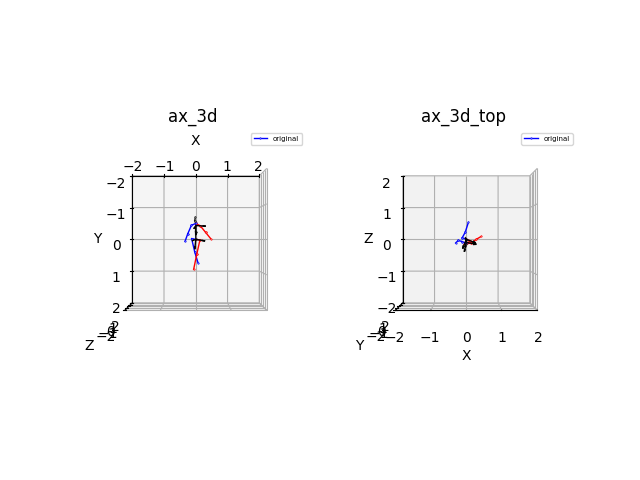

In [23]:
dataset_name = 'h36m'
data = load_data_dict(dataset_name, ['cam_3d', 'source_list'], [], verbose=True)
source = 'S1_58860488_Walking'
subject, cam_id, action = split_source_name(source, dataset_name)
print(subject, cam_id, action)
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
plot_pose_with_body_frame(cam_3d_hat, with_top=True, upper=True, lower=True, frame_num=200)

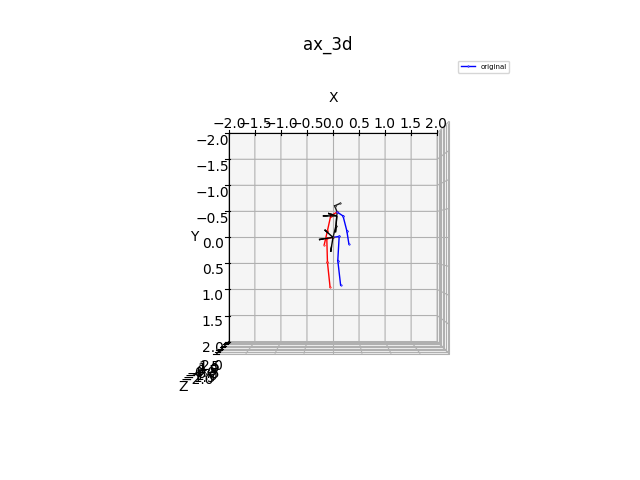

In [25]:
dataset_name = 'h36m_train'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
frame_num = 200
plot_pose_with_body_frame(cam_3d_hat, frame_num=frame_num, fig_num=f'{dataset_name}_pose_with_body_frame_frame{frame_num}')

### Get Body Frame and Azimuth / Elevation Angles

In [18]:
dataset_list = []
dataset_list += ['h36m_total', 'h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test']
dataset_list += ['fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test']
dataset_list += ['3dhp_total', '3dhp_train', '3dhp_test']
body_frame_R = {}
for dataset_name in dataset_list:
    body_frame_R[dataset_name] = {}
    cam_3d = load_total_data(dataset_name, 'cam_3d')
    lower_origin, body_frame_R[dataset_name]['lower'] = get_batch_lower_torso_frame_from_pose(cam_3d, forward_dir='-z', output_type='numpy') # lower frame
    upper_origin, body_frame_R[dataset_name]['upper'] = get_batch_upper_torso_frame_from_pose(cam_3d, forward_dir='-z', output_type='numpy') # upper frame

In [6]:
azimuth, elevation = {}, {}
for dataset_name in dataset_list:
    azimuth[dataset_name], elevation[dataset_name] = {}, {}
    azimuth[dataset_name]['lower'], elevation[dataset_name]['lower'] = rotation_to_spherical(body_frame_R[dataset_name]['lower'])
    azimuth[dataset_name]['upper'], elevation[dataset_name]['upper'] = rotation_to_spherical(body_frame_R[dataset_name]['upper'])

### Body frame distribution - 3D point cloud

In [26]:
from matplotlib.lines import lineStyles
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def set_equal_aspect_3d(ax):
    """
    Set equal aspect ratio for a 3D plot.
    """
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ranges = [abs(xlim[1] - xlim[0]), abs(ylim[1] - ylim[0]), abs(zlim[1] - zlim[0])]
    max_range = max(ranges)

    mid_x = np.mean(xlim)
    mid_y = np.mean(ylim)
    mid_z = np.mean(zlim)

    ax.set_xlim3d([mid_x - max_range / 2, mid_x + max_range / 2])
    ax.set_ylim3d([mid_y - max_range / 2, mid_y + max_range / 2])
    ax.set_zlim3d([mid_z - max_range / 2, mid_z + max_range / 2])

def plot_3d_point_cloud(rotations, frame_mode, sample_stride=1000, dpi=300, marker_style='.', marker_size=1, mode='3d', dataset='Dataset', fig_num='histogram', plt_show=True, save_fig=False):
    """
    Plot 3D point cloud representing the z-axis directions of rotation matrices.

    Parameters:
        rotations (numpy.ndarray): Dataset, array of shape (N, 3, 3).
    """
    # Extract z-axis directions
    z_axes = rotations[::sample_stride, :, 2]

    # Separate x, y, z components
    x, y, z = z_axes[:, 0], z_axes[:, 1], z_axes[:, 2]

    # Set up figure
    alpha = 0.2
    marker = marker_style
    if 'h36m' in dataset: c = 'blue'
    elif 'fit3d' in dataset: c = 'gray'
    elif '3dhp' in dataset: c = 'red'
    
    if mode == '3d':
        fig = plt.figure(num=fig_num, figsize=(5, 5))
        fig.clear()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c=c, label=dataset, alpha=alpha, marker=marker, s=marker_size)
        #ax.set_xlabel("X")
        #ax.set_ylabel("Y")
        #ax.set_zlabel("Z")
        #ax.view_init(elev=-45, azim=90)
        #ax.set_title("3D Point Cloud")
        ax.set_aspect('equal', adjustable='datalim')
        
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.zaxis.set_ticklabels([])
        #ax.axes.set_xlabel('')
        #ax.axes.set_ylabel('')
        #ax.axes.set_zlabel('')
        ax.legend().remove()
        ax.set_title('')
        # 3D 플롯의 축 내부 배경색 설정 (Axes 배경)
        ax.set_facecolor('white')  # 축 내부 배경 흰색으로 설정

        # 전체 Figure 배경색 설정
        fig.patch.set_facecolor('white')  # Figure 배경 흰색으로 설정
    else: 
        fig = plt.figure(num=fig_num, figsize=(9, 3))
        fig.clear()
        axes = fig.subplots(1, 3)
        # Plot x-y plane
        axes[0].scatter(x, y, c=c, label=dataset, alpha=alpha, marker=marker, s=marker_size)
        axes[0].add_artist(plt.Circle((0, 0), 1, color='black', fill=False, linewidth=0.2))
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y")
        axes[0].set_xlim(-1, 1)
        axes[0].set_ylim(1, -1)
        axes[0].set_title("Projection on X-Y Plane")
        #axes[0].legend()
        axes[0].set_aspect('equal', adjustable='datalim')

        # Plot y-z plane
        axes[1].scatter(z, y, c=c, label=dataset, alpha=alpha, marker=marker, s=marker_size)
        axes[1].add_artist(plt.Circle((0, 0), 1, color='black', fill=False, linewidth=0.2))
        axes[1].set_xlabel("Z")
        axes[1].set_ylabel("Y")
        axes[1].set_xlim(-1, 1)
        axes[1].set_ylim(1, -1)
        axes[1].set_title("Projection on Y-Z Plane")
        #axes[1].legend()
        axes[1].set_aspect('equal', adjustable='datalim')

        # Plot x-z plane
        axes[2].scatter(x, z, c=c, label=dataset, alpha=alpha, marker=marker, s=marker_size)
        axes[2].add_artist(plt.Circle((0, 0), 1, color='black', fill=False, linewidth=0.2))
        axes[2].set_xlabel("X")
        axes[2].set_ylabel("Z")
        axes[2].set_xlim(-1, 1)
        axes[2].set_ylim(-1, 1)
        axes[2].set_title("Projection on X-Z Plane")
        #axes[2].legend()
        axes[2].set_aspect('equal', adjustable='datalim')

    # Adjust layout
    plt.suptitle(f'{dataset}')
    plt.tight_layout()
    if plt_show: plt.show()
    if save_fig:
        save_folder = f'custom_codes/dataset_distribution_analysis/plots/body_frame_3d_point_cloud/{frame_mode}'
        if not os.path.exists(save_folder): os.makedirs(save_folder)
        save_path = os.path.join(save_folder, f'{dataset}_3d_point_cloud.svg')
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')

def plot_3d_point_cloud_comparison(rotations1, rotations2, frame_mode, dataset1='Dataset 1', dataset2='Dataset 2', fig_num='histogram', plt_show=True, save_fig=False):
    """
    Plot 3D point clouds for two datasets representing the z-axis directions of rotation matrices.

    Parameters:
        rotations1 (numpy.ndarray): First dataset, array of shape (N, 3, 3).
        rotations2 (numpy.ndarray): Second dataset, array of shape (N, 3, 3).
    """
    # Extract z-axis directions
    z_axes1 = rotations1[::500, :, 2]
    z_axes2 = rotations2[::500, :, 2]

    # Separate x, y, z components
    x1, y1, z1 = z_axes1[:, 0], z_axes1[:, 1], z_axes1[:, 2]
    x2, y2, z2 = z_axes2[:, 0], z_axes2[:, 1], z_axes2[:, 2]

    # Set up figure
    fig = plt.figure(num=fig_num, figsize=(9, 3))
    fig.clear()
    axes = fig.subplots(1, 3)
    alpha = 0.1
    marker = '.'
    if 'h36m' in dataset1: c1 = 'blue'
    elif 'fit3d' in dataset1: c1 = 'yellow'
    elif '3dhp' in dataset1: c1 = 'red'
    if 'h36m' in dataset2: c2 = 'blue'
    elif 'fit3d' in dataset2: c2 = 'yellow'
    elif '3dhp' in dataset2: c2 = 'red'

    # Plot x-y plane
    axes[0].scatter(x1, y1, c=c1, label=dataset1, alpha=alpha, marker=marker)
    axes[0].scatter(x2, y2, c=c2, label=dataset2, alpha=alpha, marker=marker)
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].set_title("Projection on X-Y Plane")
    axes[0].legend()
    axes[0].set_aspect('equal', adjustable='datalim')

    # Plot y-z plane
    axes[1].scatter(y1, z1, c=c1, label=dataset1, alpha=alpha, marker=marker)
    axes[1].scatter(y2, z2, c=c2, label=dataset2, alpha=alpha, marker=marker)
    axes[1].set_xlabel("Y")
    axes[1].set_ylabel("Z")
    axes[1].set_title("Projection on Y-Z Plane")
    axes[1].legend()
    axes[1].set_aspect('equal', adjustable='datalim')

    # Plot x-z plane
    axes[2].scatter(x1, z1, c=c1, label=dataset1, alpha=alpha, marker=marker)
    axes[2].scatter(x2, z2, c=c2, label=dataset2, alpha=alpha, marker=marker)
    axes[2].set_xlabel("X")
    axes[2].set_ylabel("Z")
    axes[2].set_title("Projection on X-Z Plane")
    axes[2].legend()
    axes[2].set_aspect('equal', adjustable='datalim')

    # Adjust layout
    plt.suptitle(f'{dataset1} vs {dataset2}')
    plt.tight_layout()
    if plt_show: plt.show()
    if save_fig: 
        save_folder = f'custom_codes/dataset_distribution_analysis/plots/body_frame_3d_point_cloud/{frame_mode}'
        if not os.path.exists(save_folder): os.makedirs(save_folder)
        save_path = os.path.join(save_folder, f'{dataset1}_vs_{dataset2}_3d_point_cloud.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

/tmp/ipykernel_237570/1171967581.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


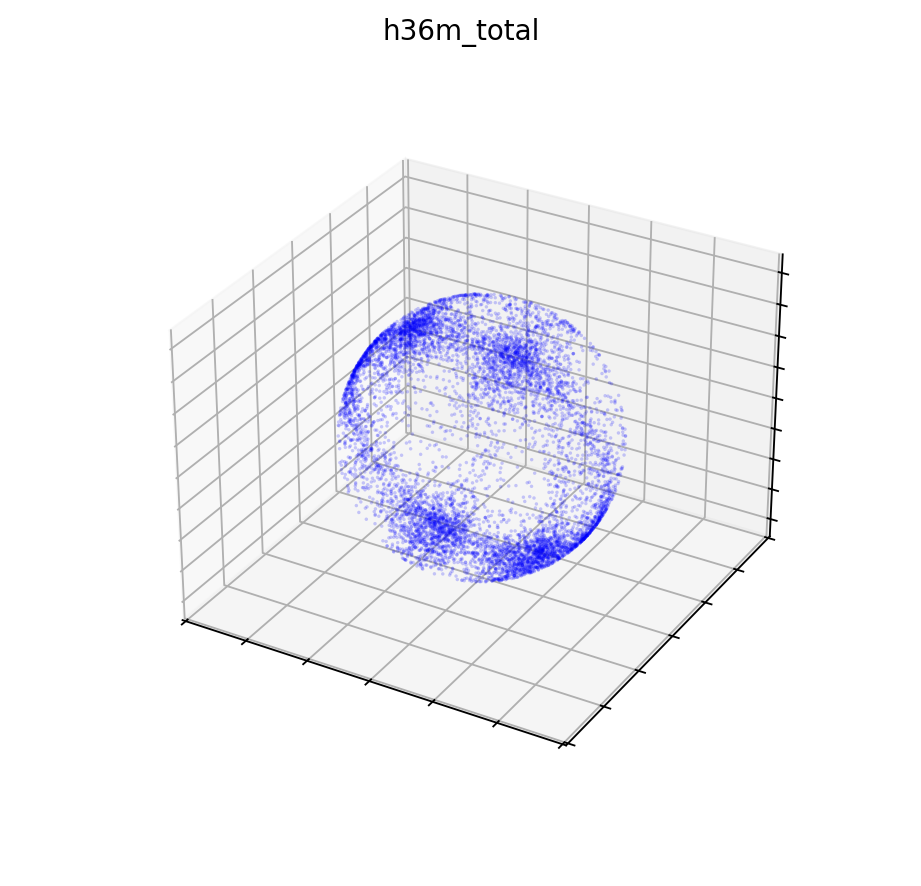

/tmp/ipykernel_237570/1171967581.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


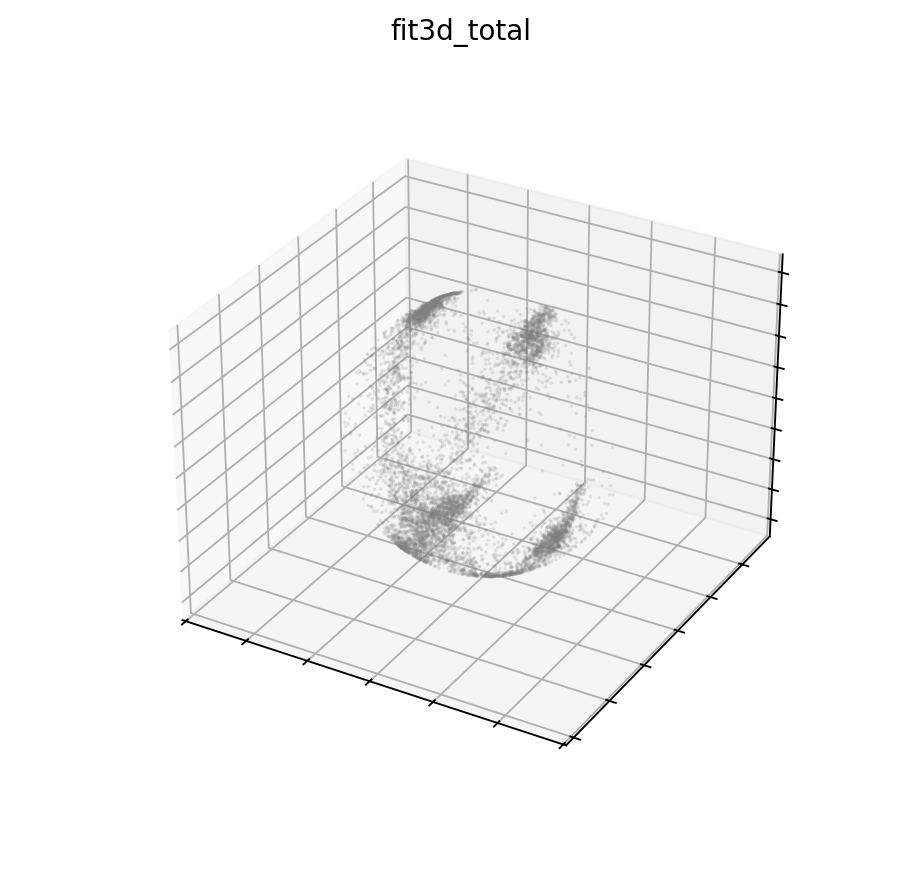

/tmp/ipykernel_237570/1171967581.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


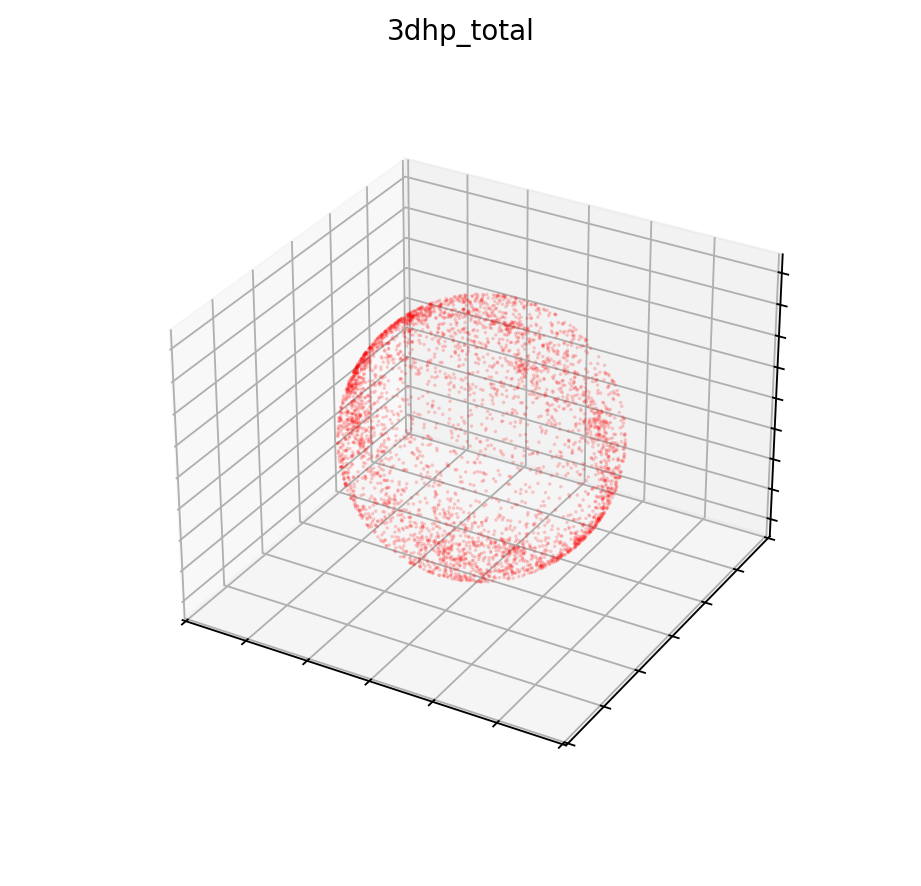

In [27]:
# one dataset
body_frame_type = 'lower'
for dataset in ['h36m_total', 'fit3d_total', '3dhp_total']:
    plot_3d_point_cloud(body_frame_R[dataset][body_frame_type], 
                        body_frame_type, 
                        mode='3d',
                        marker_style='.',
                        marker_size=1,
                        sample_stride=250, 
                        dataset=dataset, 
                        #fig_num=f'{dataset}_{body_frame_type}', 
                        plt_show=True, save_fig=True)
    ##break

In [10]:
# compare two datasets
dataset_pairs = {
    #'h36m_train': ['h36m_test', 'fit3d_total', '3dhp_train', '3dhp_test'],
    #'h36m_tr_s1_ts_s5678_train': ['h36m_tr_s1_ts_s5678_test', 'h36m_test', 'fit3d_total', '3dhp_train', '3dhp_test'],
    #'fit3d_tr_s03_train': ['fit3d_tr_s03_test', 'h36m_tr_s1_ts_s5678_test', 'h36m_test', '3dhp_train', '3dhp_test'],
    #'fit3d_ts_s4710_train': ['fit3d_ts_s4710_test', 'h36m_tr_s1_ts_s5678_test', 'h36m_test', '3dhp_train', '3dhp_test'],
    '3dhp_total': ['h36m_total', 'fit3d_total'],
    'h36m_total': ['fit3d_total'],
}

save_fig = False
plt_show = False
for dataset1 in dataset_pairs.keys():
    for dataset2 in dataset_pairs[dataset1]:
        print(f"\nComparing {dataset1} and {dataset2}...")
        lower_frame_R1 = body_frame_R[dataset1]['lower']
        lower_frame_R2 = body_frame_R[dataset2]['lower']
        upper_frame_R1 = body_frame_R[dataset1]['upper']
        upper_frame_R2 = body_frame_R[dataset2]['upper']

        # Example usage
        plot_3d_point_cloud_comparison(lower_frame_R1, lower_frame_R2, 'lower', dataset1, dataset2, fig_num=f'{dataset1}_vs_{dataset2}_lower_body_frame', plt_show=plt_show, save_fig=save_fig)
        plot_3d_point_cloud_comparison(upper_frame_R1, upper_frame_R2, 'upper', dataset1, dataset2, fig_num=f'{dataset1}_vs_{dataset2}_upper_body_frame', plt_show=plt_show, save_fig=save_fig)
        break
    break


Comparing 3dhp_total and h36m_total...


In [13]:
dataset_list = []
dataset_list += ['h36m_total', 'h36m_train', 'h36m_test', 'h36m_tr_s1_ts_s5678_train', 'h36m_tr_s1_ts_s5678_test']
dataset_list += ['fit3d_total', 'fit3d_tr_s03_train', 'fit3d_tr_s03_test', 'fit3d_ts_s4710_train', 'fit3d_ts_s4710_test']
dataset_list += ['3dhp_total', '3dhp_train', '3dhp_test']
body_frame_R_canonical = {}
for dataset_name in dataset_list:
    body_frame_R_canonical[dataset_name] = {}
    cam_3d_canonical = load_total_data(dataset_name, 'cam_3d_canonical_revolute')
    lower_origin, body_frame_R_canonical[dataset_name]['lower'] = get_batch_lower_torso_frame_from_pose(cam_3d_canonical, forward_dir='-z', output_type='numpy') # lower frame
    upper_origin, body_frame_R_canonical[dataset_name]['upper'] = get_batch_upper_torso_frame_from_pose(cam_3d_canonical, forward_dir='-z', output_type='numpy') # upper frame

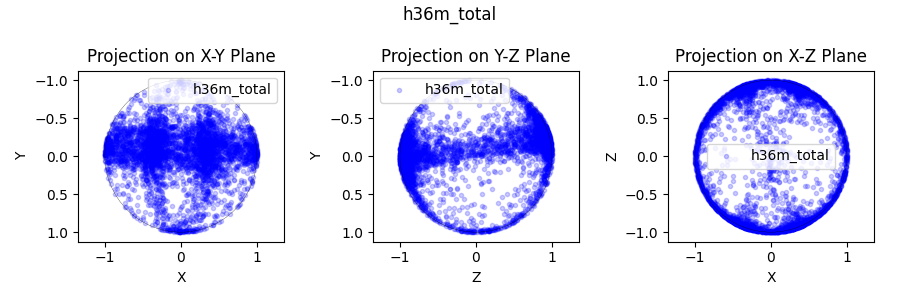

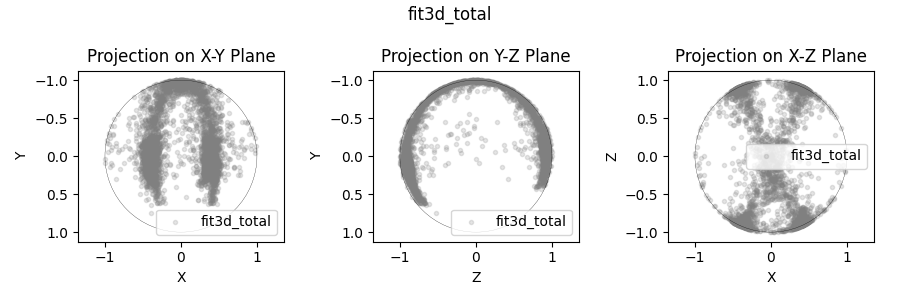

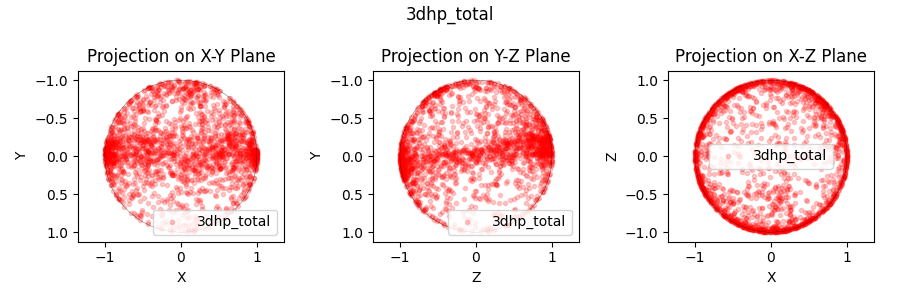

In [15]:
# one dataset
body_frame_type = 'lower'
for dataset in ['h36m_total', 'fit3d_total', '3dhp_total']:
    plot_3d_point_cloud(body_frame_R_canonical[dataset][body_frame_type], body_frame_type, dataset, fig_num=f'{dataset}_{body_frame_type}_cam_3d_canonical_revolute', plt_show=True, save_fig=False)
    #break

### Body frame distribution - azimuth, elevation

Common hist: 516600.0, Hist2: 543344.0
Overlap Ratio: 0.95
79975 12674 50938


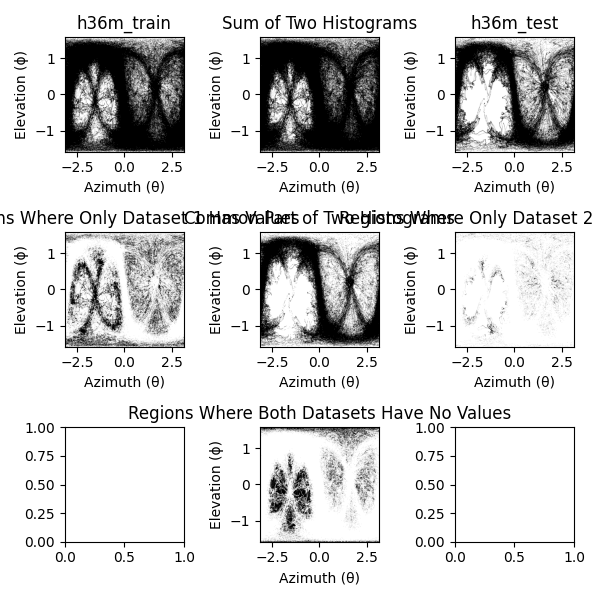

File already exists: custom_codes/dataset_distribution_analysis/plots/body_frame_similarity/body_frame_similarity_bin500_h36m_train_h36m_test_overlap_0.951.png


In [11]:
dataset_pairs = {
    'h36m_train': ['h36m_test', 'fit3d_total', '3dhp_train', '3dhp_test'],
    'h36m_tr_s1_ts_s5678_train': ['h36m_tr_s1_ts_s5678_test', 'h36m_test', 'fit3d_total', '3dhp_train', '3dhp_test'],
    'fit3d_tr_s03_train': ['fit3d_tr_s03_test', 'h36m_tr_s1_ts_s5678_test', 'h36m_test', '3dhp_train', '3dhp_test'],
    'fit3d_ts_s4710_train': ['fit3d_ts_s4710_test', 'h36m_tr_s1_ts_s5678_test', 'h36m_test', '3dhp_train', '3dhp_test'],
}

body_frame_type = 'lower' # 'upper'
overwrite = False
test_only_one = True
for dataset1 in dataset_pairs.keys():
    for dataset2 in dataset_pairs[dataset1]:
        azimuth1, elevation1 = azimuth[dataset1][body_frame_type], elevation[dataset1][body_frame_type]
        azimuth2, elevation2 = azimuth[dataset2][body_frame_type], elevation[dataset2][body_frame_type]

        # Compute histograms
        bins = 500
        hist1, xedges, yedges = compute_2d_histogram(azimuth1, elevation1, bins=bins)
        hist2, _, _ = compute_2d_histogram(azimuth2, elevation2, bins=bins, range=[[xedges[0], xedges[-1]], [yedges[0], yedges[-1]]])

        # Compute similarity metrics
        # kl_div = compute_kl_divergence(hist1, hist2)
        # #emd = compute_earth_movers_distance(hist1, hist2, xedges, yedges)
        # print(f"KL Divergence: {kl_div}")
        # print(f"Earth Mover's Distance: {emd}")
        overlap_ratio = calculate_overlap_ratio(hist1, hist2)
        print(f"Overlap Ratio: {overlap_ratio:.2f}")

        save_folder = 'custom_codes/dataset_distribution_analysis/plots/body_frame_similarity'
        if not os.path.exists(save_folder): os.makedirs(save_folder)
        save_path = os.path.join(save_folder, f'body_frame_similarity_bin{bins}_{dataset1}_{dataset2}_overlap_{overlap_ratio:.3f}.png')

        # Plot histograms
        plot_2d_histograms(hist1, hist2, xedges, yedges, dataset1=dataset1, dataset2=dataset2, fig_num=f'{dataset1}_{dataset2}_angle_histogram', plt_show=True)
        if os.path.exists(save_path) and not overwrite: print(f"File already exists: {save_path}")
        else: plt.savefig(save_path, dpi=300, bbox_inches='tight')
        if test_only_one: break
    if test_only_one: break


# Procrustes Aligned Posture diversity 

In [27]:
def plot_3d_pose_projected_on_planes(pose3d, joint_idxs=[0], bins=500, stride=1, marker_size=1, plt_show=True, save_fig=False):
    """
    Plot 3D point clouds for two datasets representing the z-axis directions of rotation matrices.

    Parameters:
        rotations1 (numpy.ndarray): First dataset, array of shape (N, 3, 3).
        rotations2 (numpy.ndarray): Second dataset, array of shape (N, 3, 3).
    """

    # Separate x, y, z components
    pose3d = pose3d[:, joint_idxs].reshape(-1, 3)
    print(pose3d.shape)
    x, y, z = pose3d[::stride, 0], pose3d[::stride, 1], pose3d[::stride, 2]

    #  # Create histograms
    # hist_xy, xedges_xy, yedges_xy = np.histogram2d(x, y, bins=bins, range=[[-1, 1], [-1, 1]], density=True)
    # hist_yz, xedges_yz, yedges_yz = np.histogram2d(y, z, bins=bins, range=[[-1, 1], [-1, 1]], density=True)
    # hist_xz, xedges_xz, yedges_xz = np.histogram2d(x, z, bins=bins, range=[[-1, 1], [-1, 1]], density=True)

    # hist_xy /= hist_xy.sum()
    # hist_yz /= hist_yz.sum()
    # hist_xz /= hist_xz.sum()

    # Set up figure
    fig = plt.figure(num='histogram', figsize=(9, 3))
    fig.clear()
    axes = fig.subplots(1, 3)

    # # X-Y plane
    # axes[0].imshow(hist_xy.T, origin='lower', extent=[xedges_xy[0], xedges_xy[-1], yedges_xy[0], yedges_xy[-1]], cmap='viridis', aspect='auto')
    # axes[0].set_title("X-Y Plane")
    # axes[0].set_xlabel("X")
    # axes[0].set_ylabel("Y")
    # axes[0].set_aspect('equal', adjustable='datalim')
    # plt.colorbar(axes[0].imshow(hist_xy.T, origin='lower', extent=[xedges_xy[0], xedges_xy[-1], yedges_xy[0], yedges_xy[-1]], cmap='viridis', aspect='auto'), ax=axes[0])
    

    # # Y-Z plane
    # axes[1].imshow(hist_yz.T, origin='lower', extent=[xedges_yz[0], xedges_yz[-1], yedges_yz[0], yedges_yz[-1]], cmap='viridis', aspect='auto')
    # axes[1].set_title("Y-Z Plane")
    # axes[1].set_xlabel("Y")
    # axes[1].set_ylabel("Z")
    # plt.colorbar(axes[1].imshow(hist_yz.T, origin='lower', extent=[xedges_yz[0], xedges_yz[-1], yedges_yz[0], yedges_yz[-1]], cmap='viridis', aspect='auto'), ax=axes[1])

    # # X-Z plane
    # axes[2].imshow(hist_xz.T, origin='lower', extent=[xedges_xz[0], xedges_xz[-1], yedges_xz[0], yedges_xz[-1]], cmap='viridis', aspect='auto')
    # axes[2].set_title("X-Z Plane")
    # axes[2].set_xlabel("X")
    # axes[2].set_ylabel("Z")
    # plt.colorbar(axes[2].imshow(hist_xz.T, origin='lower', extent=[xedges_xz[0], xedges_xz[-1], yedges_xz[0], yedges_xz[-1]], cmap='viridis', aspect='auto'), ax=axes[2])


    # Plot x-y plane
    axes[1].scatter(y, x, c='blue', label='', alpha=0.2, s=marker_size)
    axes[1].set_xlabel("Y")
    axes[1].set_ylabel("X")
    axes[1].set_xlim(-1, 1)
    axes[1].set_ylim(1, -1)
    axes[1].set_title("Projection on X-Y Plane")
    axes[1].legend()
    axes[1].set_aspect('equal', adjustable='box')

    # Plot y-z plane
    axes[0].scatter(y, z, c='blue', label='', alpha=0.2, s=marker_size)
    axes[0].set_xlabel("Y")
    axes[0].set_ylabel("Z")
    axes[0].set_xlim(-1, 1)
    axes[0].set_ylim(-1, 1)
    axes[0].set_title("Projection on Y-Z Plane")
    axes[0].legend()
    axes[0].set_aspect('equal', adjustable='box')

    # Plot x-z plane
    axes[2].scatter(z, x, c='blue', label='', alpha=0.2, s=marker_size)
    axes[2].set_xlabel("Z")
    axes[2].set_ylabel("X")
    axes[2].set_xlim(-1, 1)
    axes[2].set_ylim(1, -1)
    axes[2].set_title("Projection on X-Z Plane")
    axes[2].legend()
    axes[2].set_aspect('equal', adjustable='box')

    # Adjust layout
    #plt.suptitle(f'{dataset1} vs {dataset2}')
    plt.tight_layout()
    if plt_show: plt.show()
    # if save_fig:
    #     save_folder = f'custom_codes/dataset_distribution_analysis/plots/body_frame_3d_point_cloud/{frame_mode}'
    #     if not os.path.exists(save_folder): os.makedirs(save_folder)
    #     save_path = os.path.join(save_folder, f'{dataset1}_vs_{dataset2}_3d_point_cloud.png')
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [18]:
# h36m train
dataset_name = 'h36m_train'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_h36m_train = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_h36m_train = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_h36m_train)

# h36m test
dataset_name = 'h36m_test'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_h36m_test = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_h36m_test = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_h36m_test)

# 3dhp train
dataset_name = '3dhp_train'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_3dhp_train = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_3dhp_train = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_3dhp_train)

# 3dhp test
dataset_name = '3dhp_test'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_3dhp_test = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_3dhp_test = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_3dhp_test)

# fit3d tr_s03 train
dataset_name = 'fit3d_tr_s03_train'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_fit3d_tr_s03_train = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_fit3d_tr_s03_train = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_fit3d_tr_s03_train)

# fit3d tr_s03 test
dataset_name = 'fit3d_tr_s03_test'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_fit3d_tr_s03_test = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_fit3d_tr_s03_test = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_fit3d_tr_s03_test)

# fit3d ts_s4710 train
dataset_name = 'fit3d_ts_s4710_train'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_fit3d_ts_s4710_train = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_fit3d_ts_s4710_train = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_fit3d_ts_s4710_train)

# fit3d ts_s4710 test
dataset_name = 'fit3d_ts_s4710_test'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_fit3d_ts_s4710_test = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_fit3d_ts_s4710_test = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_fit3d_ts_s4710_test)

# fit3d total
dataset_name = 'fit3d_total'
cam_3d = load_total_data(dataset_name, 'cam_3d')
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
_, lower_frame_R_fit3d_total = get_batch_lower_torso_frame_from_pose(cam_3d_hat, forward_dir='-z', output_type='numpy')
cam_3d_hat_rotated_by_lower_fit3d_total = np.einsum('nij,njk->nik', cam_3d_hat, lower_frame_R_fit3d_total)


(5803182, 3)


/tmp/ipykernel_65645/1604522577.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_65645/1604522577.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipykernel_65645/1604522577.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


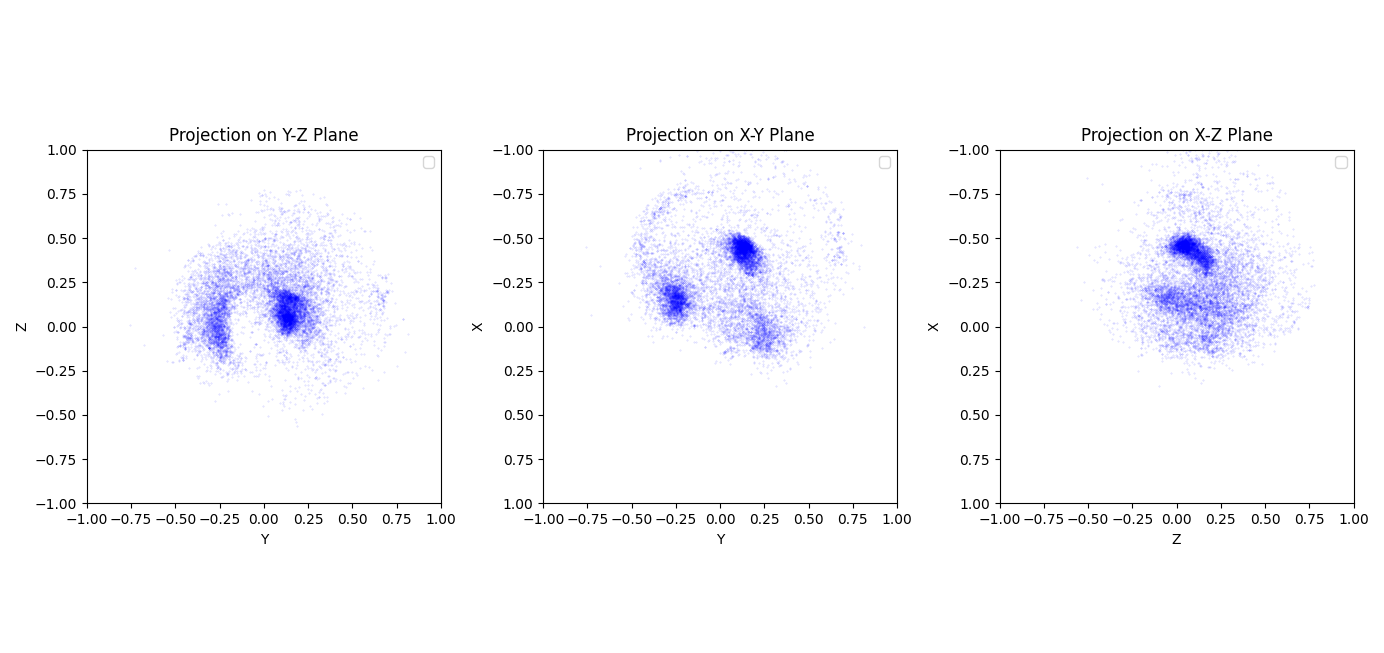

In [33]:
h36m_keypoints = ['Pelvis','R_Hip','R_Knee','R_Ankle','L_Hip','L_Knee','L_Ankle','Torso','Neck','Nose','Head','L_Shoulder','L_Elbow','L_Wrist','R_Shoulder','R_Elbow','R_Wrist']
arm_keypoints = ['L_Shoulder','L_Elbow','L_Wrist','R_Shoulder','R_Elbow','R_Wrist']
leg_keypoints = ['R_Hip','R_Knee','R_Ankle','L_Hip','L_Knee','L_Ankle']
joint_name = arm_keypoints
joint_idxs = get_h36m_keypoint_index(joint_name)
plot_3d_pose_projected_on_planes(cam_3d_hat_rotated_by_lower_3dhp_train,
                                 stride=500,
                                 joint_idxs=joint_idxs,
                                 marker_size=0.1,
                                 plt_show=True,
                                 save_fig=False)

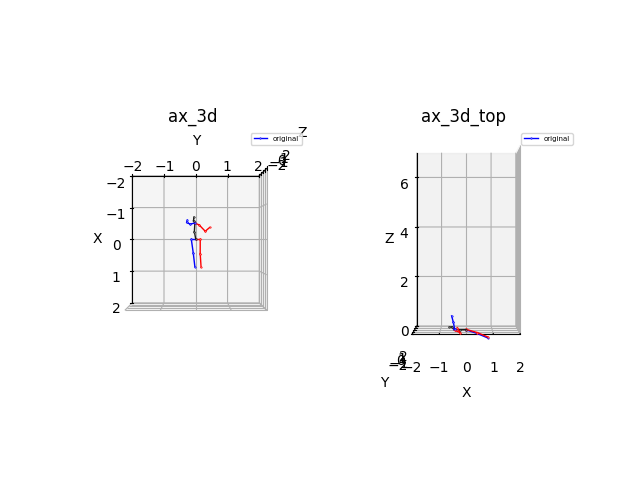

In [10]:
%matplotlib widget
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'view': (90, 0)},
    'ax_3d_top': {'type': '3d', 'loc': 122, 'mode': 'cam_top', 'zlim': [0, 7]},
}

fig, axs = generate_axes('test', configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_hat_rotated,      {'color': '', 'label': 'original'}),
    ('ax_3d_top', cam_3d_hat_rotated, {'color': '', 'label': 'original'})
]

frame_num=120030
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

# Generate sample video example

In [5]:
data = data_fit3d
dataset_name = 'fit3d'
source_list = data['source_list'].copy()
subject, cam_id, action = split_source_name(source_list[0], dataset_name)
cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
# original 3D/2D pose
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
img_2d = data['img_2d'][subject][action][cam_id].copy()
img_2d_centered = img_2d.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
img_2d_canonical_pcl_original = data['img_2d_canonical_pcl_original'][subject][action][cam_id].copy()
img_2d_canonical_pcl = data['img_2d_canonical_pcl'][subject][action][cam_id].copy()

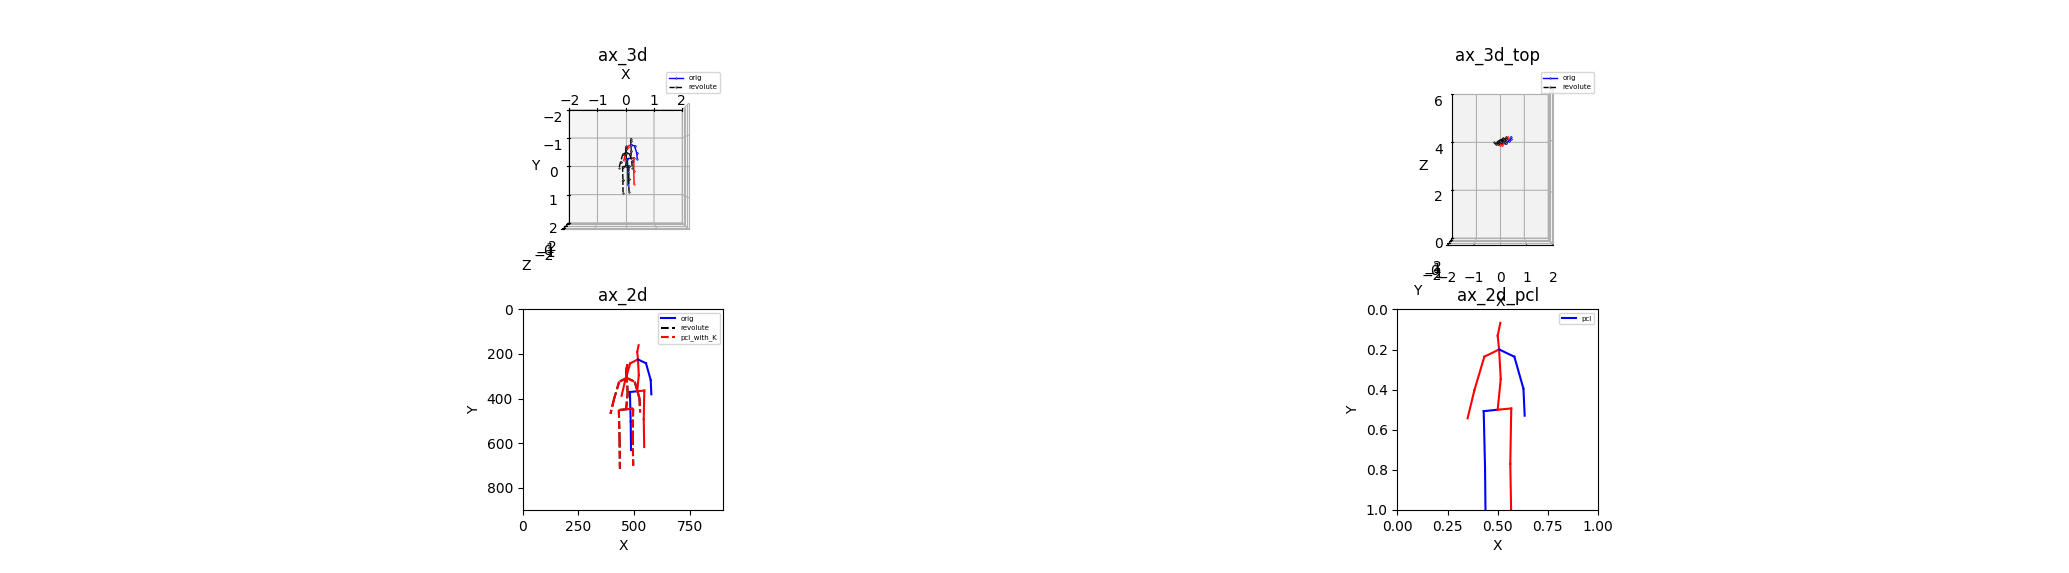

In [7]:
%matplotlib widget
# check original train data
frame_num = -1
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam'},
    'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_pcl': {'type': '2d', 'loc': 224, 'W': 1, 'H': 1},
}

fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d',     cam_3d,                           {'color': '', 'label': 'orig'}),
    ('ax_3d_top', cam_3d,                           {'color': '', 'label': 'orig'}),
    ('ax_2d',     img_2d,                           {'color': '', 'label': 'orig'}),
    ('ax_3d',     cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
    ('ax_3d_top', cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
    ('ax_2d',     img_2d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
    ('ax_2d', img_2d_canonical_pcl,                 {'color': 'r', 'label': 'pcl_with_K', 'linestyle': '--'}),
    ('ax_2d_pcl', img_2d_canonical_pcl_original,    {'color': '', 'label': 'pcl'}),
    
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [12]:
# save video
save_folder = f'/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/{dataset_name}'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
generate_plot_video(fig, f'{save_folder}/{subject}_{action}_{cam_id}.mp4', len(img_2d), lambda x: general_plot_func(axs, configs, plot_pose_setting, x), fps=5, stride=6, overwrite=False)

  0%|          | 0/68 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2058, 1452) to (2064, 1456) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s04_warmup_7_50591643.mp4


### Generate sample videos - Fit3D

In [22]:
data = data_fit3d
dataset_name = 'fit3d'

# shuffle source_list
source_list = data['source_list'].copy()
np.random.seed(0)
np.random.shuffle(source_list)
for source in source_list[:20]:
    subject, cam_id, action = split_source_name(source, dataset_name)
    save_folder = f'/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/{dataset_name}'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = f'{save_folder}/{subject}_{action}_{cam_id}.mp4'
    if os.path.exists(save_path): 
        print(f'{save_path} already exists')
        continue
    print(f"{subject}_{action}_{cam_id}")

    cam_param = data['cam_param'][subject][action][cam_id].copy()
    W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
    fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
    # original 3D/2D pose
    cam_3d = data['cam_3d'][subject][action][cam_id].copy()
    img_2d = data['img_2d'][subject][action][cam_id].copy()
    img_2d_centered = img_2d.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
    cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
    img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
    img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
    img_2d_canonical_pcl_original = data['img_2d_canonical_pcl_original'][subject][action][cam_id].copy()

    configs = {
        'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam'},
        'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
        'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
        'ax_2d_pcl': {'type': '2d', 'loc': 224, 'W': 1, 'H': 1},
    }
    fig, axs = generate_axes(2, configs, fig_title='')

    plot_pose_setting = [
        ('ax_3d',     cam_3d,                           {'color': '', 'label': 'orig'}),
        ('ax_3d_top', cam_3d,                           {'color': '', 'label': 'orig'}),
        ('ax_2d',     img_2d,                           {'color': '', 'label': 'orig'}),
        ('ax_3d',     cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_3d_top', cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_2d',     img_2d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_2d_pcl', img_2d_canonical_pcl_original,    {'color': '', 'label': 'pcl'}),
    ]

    # save video
    generate_plot_video(fig, save_path, len(img_2d), lambda x: general_plot_func(axs, configs, plot_pose_setting, x), fps=5, stride=6, overwrite=False)

/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s05_pushup_50591643.mp4 already exists
/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s04_squat_58860488.mp4 already exists
s03_warmup_2_58860488


100%|██████████| 224/224 [00:30<00:00,  7.23it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s03_warmup_2_58860488.mp4
s07_warmup_1_65906101


100%|██████████| 293/293 [00:39<00:00,  7.38it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s07_warmup_1_65906101.mp4
s11_warmup_13_50591643


100%|██████████| 204/204 [00:28<00:00,  7.26it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s11_warmup_13_50591643.mp4
s08_barbell_dead_row_65906101


100%|██████████| 154/154 [00:21<00:00,  7.29it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s08_barbell_dead_row_65906101.mp4
s04_dumbbell_reverse_lunge_65906101


100%|██████████| 191/191 [00:26<00:00,  7.18it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s04_dumbbell_reverse_lunge_65906101.mp4
s05_standing_ab_twists_50591643


100%|██████████| 167/167 [00:22<00:00,  7.33it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s05_standing_ab_twists_50591643.mp4
s09_warmup_6_50591643


100%|██████████| 203/203 [00:27<00:00,  7.31it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s09_warmup_6_50591643.mp4
s10_warmup_13_65906101


100%|██████████| 194/194 [00:26<00:00,  7.30it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s10_warmup_13_65906101.mp4
s08_one_arm_row_65906101


100%|██████████| 103/103 [00:14<00:00,  7.20it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s08_one_arm_row_65906101.mp4
s05_barbell_shrug_58860488


100%|██████████| 139/139 [00:19<00:00,  7.23it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s05_barbell_shrug_58860488.mp4
s05_warmup_10_58860488


100%|██████████| 125/125 [00:17<00:00,  7.07it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s05_warmup_10_58860488.mp4
s10_warmup_10_50591643


100%|██████████| 156/156 [00:21<00:00,  7.27it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s10_warmup_10_50591643.mp4
s04_drag_curl_65906101


100%|██████████| 274/274 [00:37<00:00,  7.24it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s04_drag_curl_65906101.mp4
s10_standing_ab_twists_50591643


100%|██████████| 177/177 [00:24<00:00,  7.25it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s10_standing_ab_twists_50591643.mp4
s08_man_maker_60457274


100%|██████████| 366/366 [00:50<00:00,  7.28it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s08_man_maker_60457274.mp4
s05_warmup_3_60457274


100%|██████████| 228/228 [00:31<00:00,  7.28it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s05_warmup_3_60457274.mp4
s03_dumbbell_high_pulls_58860488


100%|██████████| 154/154 [00:20<00:00,  7.43it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s03_dumbbell_high_pulls_58860488.mp4
s07_diamond_pushup_60457274


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/fit3d/s07_diamond_pushup_60457274.mp4


### Generate sample videos - 3DHP TRAIN

In [3]:
data = data_3dhp
dataset_name = '3dhp'
source_list = data['source_list'].copy()
source_list_train = [x for x in source_list if ('TS' not in x) and (x.split('_')[1] in ['cam0', 'cam1', 'cam2', 'cam4', 'cam5', 'cam6', 'cam7', 'cam8'])]
source_list_test = [x for x in source_list if 'TS' in x]
np.random.seed(0)
np.random.shuffle(source_list_train)
#source_list_train[:20], source_list_test

In [4]:
# shuffle source_list
for source in source_list_train[:50]:
    subject, cam_id, action = split_source_name(source, dataset_name)
    save_folder = f'/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/{dataset_name}'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = f'{save_folder}/{subject}_{action}_{cam_id}.mp4'
    if os.path.exists(save_path): 
        print(f'{save_path} already exists')
        continue
    print(f"{subject}_{action}_{cam_id}")

    cam_param = data['cam_param'][subject][action][cam_id].copy()
    W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
    fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
    # original 3D/2D pose
    cam_3d = data['cam_3d'][subject][action][cam_id].copy()
    img_2d = data['img_2d'][subject][action][cam_id].copy()
    img_2d_centered = img_2d.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
    cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
    img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
    img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
    img_2d_canonical_pcl_original = data['img_2d_canonical_pcl_original'][subject][action][cam_id].copy()

    configs = {
        'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam'},
        'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
        'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
        'ax_2d_pcl': {'type': '2d', 'loc': 224, 'W': 1, 'H': 1},
    }
    fig, axs = generate_axes(2, configs, fig_title='')

    plot_pose_setting = [
        ('ax_3d',     cam_3d,                           {'color': '', 'label': 'orig'}),
        ('ax_3d_top', cam_3d,                           {'color': '', 'label': 'orig'}),
        ('ax_2d',     img_2d,                           {'color': '', 'label': 'orig'}),
        ('ax_3d',     cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_3d_top', cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_2d',     img_2d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_2d_pcl', img_2d_canonical_pcl_original,    {'color': '', 'label': 'pcl'}),
    ]

    # save video
    generate_plot_video(fig, save_path, len(img_2d), lambda x: general_plot_func(axs, configs, plot_pose_setting, x), fps=5, stride=6, overwrite=False)

S3_Seq2_cam0


100%|██████████| 1971/1971 [04:07<00:00,  7.96it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S3_Seq2_cam0.mp4
S2_Seq2_cam0


100%|██████████| 938/938 [02:01<00:00,  7.74it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S2_Seq2_cam0.mp4
S6_Seq1_cam7


100%|██████████| 966/966 [02:03<00:00,  7.81it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq1_cam7.mp4
S4_Seq1_cam4


100%|██████████| 947/947 [01:58<00:00,  7.97it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq1_cam4.mp4
S1_Seq2_cam0


100%|██████████| 1811/1811 [03:47<00:00,  7.98it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq2_cam0.mp4
S7_Seq2_cam5


100%|██████████| 1051/1051 [02:12<00:00,  7.92it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq2_cam5.mp4
S8_Seq2_cam8


100%|██████████| 980/980 [02:03<00:00,  7.94it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S8_Seq2_cam8.mp4
S7_Seq1_cam0


100%|██████████| 1007/1007 [02:07<00:00,  7.88it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq1_cam0.mp4
S5_Seq2_cam1


100%|██████████| 1999/1999 [04:11<00:00,  7.93it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S5_Seq2_cam1.mp4
S1_Seq1_cam8


100%|██████████| 863/863 [01:50<00:00,  7.82it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq1_cam8.mp4
S4_Seq2_cam5


100%|██████████| 1101/1101 [02:19<00:00,  7.90it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq2_cam5.mp4
S1_Seq2_cam2


100%|██████████| 1805/1805 [03:44<00:00,  8.03it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq2_cam2.mp4
S6_Seq2_cam1


100%|██████████| 1013/1013 [02:06<00:00,  7.99it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam1.mp4
S6_Seq2_cam7


100%|██████████| 945/945 [01:58<00:00,  7.97it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam7.mp4
S2_Seq2_cam7


100%|██████████| 646/646 [01:20<00:00,  8.00it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S2_Seq2_cam7.mp4
S3_Seq1_cam1


100%|██████████| 1988/1988 [04:07<00:00,  8.04it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S3_Seq1_cam1.mp4
S1_Seq1_cam2


100%|██████████| 836/836 [01:45<00:00,  7.94it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq1_cam2.mp4
S4_Seq2_cam4


100%|██████████| 1033/1033 [02:08<00:00,  8.04it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq2_cam4.mp4
S4_Seq1_cam2


100%|██████████| 903/903 [01:56<00:00,  7.77it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq1_cam2.mp4
S2_Seq2_cam2


100%|██████████| 947/947 [01:58<00:00,  7.97it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S2_Seq2_cam2.mp4
S2_Seq1_cam7


100%|██████████| 802/802 [01:42<00:00,  7.83it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S2_Seq1_cam7.mp4
S7_Seq1_cam6


100%|██████████| 1035/1035 [02:10<00:00,  7.94it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq1_cam6.mp4
S4_Seq1_cam0


100%|██████████| 963/963 [02:03<00:00,  7.78it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq1_cam0.mp4
S5_Seq1_cam5


100%|██████████| 2027/2027 [04:17<00:00,  7.87it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S5_Seq1_cam5.mp4
S8_Seq2_cam1


100%|██████████| 1003/1003 [02:04<00:00,  8.03it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S8_Seq2_cam1.mp4
S8_Seq2_cam2


100%|██████████| 938/938 [01:59<00:00,  7.83it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S8_Seq2_cam2.mp4
S6_Seq2_cam4


100%|██████████| 977/977 [02:01<00:00,  8.01it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam4.mp4
S2_Seq1_cam0


100%|██████████| 900/900 [01:53<00:00,  7.93it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S2_Seq1_cam0.mp4
S6_Seq2_cam2


100%|██████████| 984/984 [02:04<00:00,  7.89it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam2.mp4
/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S8_Seq1_cam7.mp4 already exists
S1_Seq2_cam6


100%|██████████| 1975/1975 [04:03<00:00,  8.12it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq2_cam6.mp4
S7_Seq1_cam4


100%|██████████| 1017/1017 [02:06<00:00,  8.04it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq1_cam4.mp4
S5_Seq2_cam5


100%|██████████| 2013/2013 [04:11<00:00,  8.00it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S5_Seq2_cam5.mp4
S3_Seq2_cam4


100%|██████████| 1729/1729 [03:37<00:00,  7.96it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S3_Seq2_cam4.mp4
S1_Seq2_cam8


100%|██████████| 1942/1942 [04:01<00:00,  8.03it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq2_cam8.mp4
S6_Seq2_cam6


100%|██████████| 996/996 [02:07<00:00,  7.83it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam6.mp4
S6_Seq2_cam8


100%|██████████| 1014/1014 [02:07<00:00,  7.97it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam8.mp4
S3_Seq2_cam6


100%|██████████| 1948/1948 [04:01<00:00,  8.05it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S3_Seq2_cam6.mp4
S1_Seq1_cam4


100%|██████████| 922/922 [01:54<00:00,  8.06it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq1_cam4.mp4
S7_Seq1_cam5


100%|██████████| 1026/1026 [02:09<00:00,  7.90it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq1_cam5.mp4
S1_Seq1_cam7


100%|██████████| 838/838 [01:46<00:00,  7.89it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S1_Seq1_cam7.mp4
S6_Seq2_cam5


100%|██████████| 1015/1015 [02:07<00:00,  7.96it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq2_cam5.mp4
S4_Seq1_cam5


100%|██████████| 1029/1029 [02:07<00:00,  8.10it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq1_cam5.mp4
/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq1_cam1.mp4 already exists
S4_Seq2_cam7


100%|██████████| 920/920 [01:53<00:00,  8.08it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq2_cam7.mp4
S7_Seq2_cam8


100%|██████████| 1042/1042 [02:12<00:00,  7.89it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S7_Seq2_cam8.mp4
S4_Seq1_cam7


100%|██████████| 841/841 [01:44<00:00,  8.01it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S4_Seq1_cam7.mp4
S6_Seq1_cam6


100%|██████████| 1020/1020 [02:08<00:00,  7.91it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S6_Seq1_cam6.mp4
S8_Seq2_cam6


100%|██████████| 995/995 [02:04<00:00,  8.00it/s]


Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S8_Seq2_cam6.mp4
S2_Seq2_cam4


100%|██████████| 890/890 [01:52<00:00,  7.91it/s]

Saved: /home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/3dhp/S2_Seq2_cam4.mp4


In [ ]:
data = data_h36m
dataset_name = 'h36m'

# shuffle source_list
source_list = data['source_list'].copy()
np.random.seed(0)
np.random.shuffle(source_list)
for source in source_list[:20]:
    subject, cam_id, action = split_source_name(source, dataset_name)
    save_folder = f'/home/lhs/codes/MotionBERT/videos/revolue_pcl_anaylsis/{dataset_name}'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = f'{save_folder}/{subject}_{action}_{cam_id}.mp4'
    if os.path.exists(save_path): 
        print(f'{save_path} already exists')
        continue
    print(f"{subject}_{action}_{cam_id}")

    cam_param = data['cam_param'][subject][action][cam_id].copy()
    W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
    fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
    # original 3D/2D pose
    cam_3d = data['cam_3d'][subject][action][cam_id].copy()
    img_2d = data['img_2d'][subject][action][cam_id].copy()
    img_2d_centered = img_2d.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
    cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
    img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
    img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - np.array([cx, cy]) + np.array([W//2, H//2])
    img_2d_canonical_pcl_original = data['img_2d_canonical_pcl_original'][subject][action][cam_id].copy()

    configs = {
        'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam'},
        'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
        'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
        'ax_2d_pcl': {'type': '2d', 'loc': 224, 'W': 1, 'H': 1},
    }
    fig, axs = generate_axes(2, configs, fig_title='')
    plot_pose_setting = [
        ('ax_3d',     cam_3d,                           {'color': '', 'label': 'orig'}),
        ('ax_3d_top', cam_3d,                           {'color': '', 'label': 'orig'}),
        ('ax_2d',     img_2d,                           {'color': '', 'label': 'orig'}),
        ('ax_3d',     cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_3d_top', cam_3d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_2d',     img_2d_canonical_revolute,        {'color': 'k', 'label': 'revolute', 'linestyle': '--'}),
        ('ax_2d_pcl', img_2d_canonical_pcl_original,    {'color': '', 'label': 'pcl'}),
    ]

    # save video
    generate_plot_video(fig, save_path, len(img_2d), lambda x: general_plot_func(axs, configs, plot_pose_setting, x), fps=5, stride=6, overwrite=False)